### DMA Assignment 3

#### Stage 2

In this stage, we are trying to predict that given we know the customer will buy in this session, which items will they buy from the list of items that they have clicked on.

In [1]:
#import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
#features selection and class imbalance
from sklearn.feature_selection import RFE, VarianceThreshold
from sklearn.kernel_approximation import RBFSampler
from sklearn.preprocessing import StandardScaler
from sklearn.kernel_approximation import PolynomialCountSketch
from sklearn.pipeline import Pipeline, make_pipeline
#machine learning models
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import AdaBoostClassifier
#model performance evaluation
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold, cross_val_score
from sklearn.metrics import ConfusionMatrixDisplay, roc_auc_score, roc_curve, confusion_matrix
from sklearn.metrics import classification_report, accuracy_score

In [2]:
#load dataset
train_data = pd.read_csv("Item_level_train.csv")
test_data = pd.read_csv("Item_level_test.csv")

In [3]:
train_data.head(10)

,Unnamed: 0,Session ID,Item ID,item_clicked_more_than_once,clicks_per_item,ratio_clicks_item_FI5,Avg_item_price,Popularity,Popularity_Rank,Item_Bought_flag,...,max_hour,max_day,max_month,item_clicked_first_f,item_clicked_last_f,clicks_bf_first_click,clicks_bf_last_click,time_bf_first_click,time_bf_last_click,avg_time_spent_item
0,0,11,214821275,1,2,0.333333,1047.129032,0.201389,3150.0,0.0,...,10,3,4,1,0,1.0,2.0,0.0,26.0,0.034483
1,2,11,214821371,1,6,1.000000,1046.000000,0.359932,2365.0,1.0,...,10,3,4,0,0,3.0,5.0,54.0,141.0,0.200937
2,8,11,214717089,0,1,0.166667,1360.000000,0.299065,2690.0,0.0,...,10,3,4,0,0,6.0,6.0,526.0,526.0,0.034483
3,9,11,214563337,0,1,0.166667,1046.000000,0.026975,3898.0,0.0,...,10,3,4,0,0,7.0,7.0,554.0,554.0,0.113665
4,10,11,214706462,0,1,0.166667,941.000000,0.060606,3766.0,0.0,...,10,3,4,0,0,8.0,8.0,643.0,643.0,0.035760
5,11,11,214717436,0,1,0.166667,1087.700000,0.201299,3151.0,0.0,...,10,3,4,0,0,9.0,9.0,671.0,671.0,0.054917
6,12,11,214743335,0,1,0.166667,939.142857,0.082300,3671.0,0.0,...,10,3,4,0,0,10.0,10.0,714.0,714.0,0.061303
7,13,11,214826837,0,1,0.166667,627.000000,0.395349,2159.0,0.0,...,10,3,4,0,0,11.0,11.0,763.0,763.0,0.025543
8,14,11,214819762,0,1,0.166667,652.274021,0.174074,3273.0,0.0,...,10,3,4,0,1,12.0,12.0,783.0,783.0,0.000000
9,15,12,214717867,1,2,1.000000,1749.868852,0.236527,2998.0,1.0,...,10,2,4,1,1,1.0,2.0,0.0,179.0,1.000000


In [4]:
test_data.head(10)

,Unnamed: 0,Session ID,Item ID,item_clicked_more_than_once,clicks_per_item,ratio_clicks_item_FI5,Avg_item_price,Popularity,Popularity_Rank,Item_Bought_flag,...,max_hour,max_day,max_month,item_clicked_first_f,item_clicked_last_f,clicks_bf_first_click,clicks_bf_last_click,time_bf_first_click,time_bf_last_click,avg_time_spent_item
0,0,9293637,214680371,1,2,1.000000,10028.671910,0.531250,467.0,1.0,...,7,0,9,0,1.0,1.0,2.0,0.0,87.0,1.000000
1,2,9293662,214677615,1,2,1.000000,1151.000000,0.440741,617.0,1.0,...,7,0,9,0,1.0,1.0,2.0,0.0,757.0,1.000000
2,4,9293704,214846258,1,4,1.000000,941.000000,0.396040,686.0,1.0,...,18,0,9,0,1.0,1.0,2.0,0.0,210.0,1.000000
3,8,9293797,214663310,0,1,1.000000,10471.000000,0.376623,718.0,0.0,...,16,0,9,0,0.0,1.0,1.0,0.0,0.0,0.581571
4,9,9293797,214822082,0,1,1.000000,1042.000000,0.250000,923.0,1.0,...,16,0,9,0,0.0,2.0,2.0,385.0,385.0,0.344411
5,10,9293797,214854060,0,1,1.000000,1047.375546,0.555874,425.0,0.0,...,16,0,9,0,0.0,3.0,3.0,613.0,613.0,0.074018
6,11,9293797,214854118,0,1,1.000000,1364.502297,0.592092,363.0,0.0,...,16,0,9,0,1.0,4.0,4.0,662.0,662.0,0.000000
7,12,9293363,214853992,1,2,0.666667,628.756629,0.684800,207.0,1.0,...,12,0,9,0,0.0,1.0,8.0,0.0,234.0,0.051680
8,13,9293363,214853865,1,3,1.000000,418.666189,0.511450,506.0,1.0,...,12,0,9,0,0.0,2.0,15.0,51.0,672.0,0.056848
9,14,9293363,214854172,0,1,0.333333,1047.478873,0.399038,679.0,1.0,...,12,0,9,0,0.0,3.0,3.0,100.0,100.0,0.042636


In [5]:
test_data["Category_flag"].unique()

array(['Offer', 'Regular', 'No Category', 'Sports'], dtype=object)

When inspecting the dataset, we observed that we need to transform the Category_flag feature to dummy variables before running our model. We also dropped columns that will not be needed later on.

In [6]:
#add dummy columns for categorical data
train_data = pd.get_dummies(train_data, columns = ["Category_flag"])
test_data = pd.get_dummies(test_data, columns = ["Category_flag"])
#drop unnecessary columns
train_data = train_data.drop("Unnamed: 0", axis=1)
test_data = test_data.drop("Unnamed: 0", axis=1)

## Sample Data - Model Performance Comparison

As we have a large dataset, we will compare model performance based on a small subset of data. In this case, we will use latest month data to run our models, make predictions, and compare performances. In this case, we will split the test_data, which also is latest 1-month data, into training set and testing set using 75:25 ratio. 

As observed below, our data is relatively balanced with ratio 55:45 between 0 and 1 class so we will not need to balance the data before running our model.

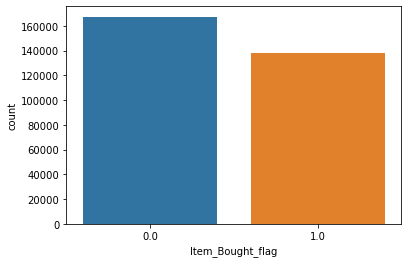

In [7]:
#split 1 month data to training and testing data 
train, test = np.split(test_data, [int(0.75*len(test_data))])
#check if training data is balanced or not
sns.countplot(x = "Item_Bought_flag", data=train)

Compare to question 1, the sample dataset in question 2 is much smaller, which allows us to test a wider range of models to find the best model for our dataset. We will compare the performances of 9 different models: Logistic Regression, XGBoost, Support Vector Machine (SVM), Neural Networks, Random Forest, CatBoost, Light GBM, Stack Classifier, and AdaBoost.

### 1. Logistic Regression

Logistic Regression is a discriminative classifier that uses a linear regression model to represent the probability through a logistic function in matrix notation: 
\begin{equation}
p(X) = \frac{exp(w^Tx)}{1+exp(w^Tx)}
\end{equation}
where $w^T$ represents the matrix for coefficients for each feature and x represents the observations. 

Logistic regression is popular machine learning method for binary classification. While simple, it gives good accuracy and has low training time. Additionally, it outputs a probability of the event being classified as class 0 or 1, which can then be adjusted using different threshold values depending on our classification purpose. For example, if the cost of misclassifying class 1 is too high, we would want to have a higher recall rate for class 1, thus we can do so by increasing the threshold value for the model to classify obsevation as class 1.  

In [8]:
#split to X and y (target variable)
X_train = train.drop(["Item_Bought_flag", "Session ID", "Item ID"], axis=1)
y_train = train["Item_Bought_flag"]
#split for test data
X_test = test.drop(["Item_Bought_flag", "Session ID", "Item ID"], axis=1)
y_test = test["Item_Bought_flag"]

Varariance Threshold method is used for dimension reduction because we have categorical features that contains very few values of 1, which will cause singular matrix error when running Logistic Regression. 

In [9]:
#features selection using variance threshold - eliminate features that have low variance
def variance_threshold_selector(data, threshold=0.5):
    # https://stackoverflow.com/a/39813304/1956309
    selector = VarianceThreshold(threshold)
    selector.fit(data)
    return data[data.columns[selector.get_support(indices=True)]]

# min_variance = .9 * (1 - .9)  
min_variance = 0.0001
low_variance = variance_threshold_selector(X_train, min_variance) 
LR_Xtrain = low_variance
cols = LR_Xtrain.columns
LR_Xtest = X_test[cols]

We then check for correlations between the remaining variables to watch out for multicollinearity issues.

In [1]:
#check for correlations between independent variables
sns.clustermap(LR_Xtrain.corr())

NameError: name 'sns' is not defined

In [11]:
logit_model = sm.Logit(y_train,LR_Xtrain)
result = logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.489987
         Iterations 7
                                Results: Logit
Model:                   Logit                Pseudo R-squared:     0.288      
Dependent Variable:      Item_Bought_flag     AIC:                  299772.8890
Date:                    2021-06-09 15:42     BIC:                  299953.6142
No. Observations:        305864               Log-Likelihood:       -1.4987e+05
Df Model:                16                   LL-Null:              -2.1063e+05
Df Residuals:            305847               LLR p-value:          0.0000     
Converged:               1.0000               Scale:                1.0000     
No. Iterations:          7.0000                                                
-------------------------------------------------------------------------------
                             Coef.   Std.Err.    z     P>|z|   [0.025   0.975] 
---------------------------------------------------

From the results above, max_day has a p-value of higher than 0.05, which means it is not a significant variable to our model so we can remove it.

In [12]:
LR_Xtrain = LR_Xtrain.drop("max_day", axis = 1)
LR_Xtest = LR_Xtest.drop("max_day", axis = 1)

In [13]:
logit_model = sm.Logit(y_train,LR_Xtrain)
result = logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.489989
         Iterations 7
                                Results: Logit
Model:                   Logit                Pseudo R-squared:     0.288      
Dependent Variable:      Item_Bought_flag     AIC:                  299772.1880
Date:                    2021-06-09 15:42     BIC:                  299942.2823
No. Observations:        305864               Log-Likelihood:       -1.4987e+05
Df Model:                15                   LL-Null:              -2.1063e+05
Df Residuals:            305848               LLR p-value:          0.0000     
Converged:               1.0000               Scale:                1.0000     
No. Iterations:          7.0000                                                
-------------------------------------------------------------------------------
                             Coef.   Std.Err.    z     P>|z|   [0.025   0.975] 
---------------------------------------------------

Then, we optimise the Logistic Regression model by C or regularisation parameter, and penalty term. The larger the value of C, the higher the tolerance for misclassification. 

In [14]:
#Fit Logistic Regression on new dataset
params = {"C": [0.1, 1, 10, 100, 500, 1000],
    "penalty": ["l2", "l1", "elasticnet", "none"]}
model = LogisticRegression(solver ='saga') #saga supports all penalty and faster for large dataset
logreg = GridSearchCV(model, param_grid=params, n_jobs=-1, cv=5, scoring='roc_auc', refit=True)
logreg.fit(LR_Xtrain, y_train)
logreg.best_estimator_

C:\Users\lilya\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.79262058 0.7926208         nan 0.79262079 0.79262082 0.79262083
        nan 0.79262084 0.79262084 0.79262074        nan 0.79262075
 0.79262081 0.79262074        nan 0.79262081 0.79262079 0.79262074
        nan 0.79262075 0.79262078 0.79262077        nan 0.79262076]
  warnings.warn(
C:\Users\lilya\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


LogisticRegression(C=10, solver='saga')

In [16]:
#make predictions using LR model
y_pred = logreg.predict(LR_Xtest)

To analyse the Logistic Regression model performance, we will use the Receiver Operating Characteristic (ROC) Curve to find the optimal threshold as we look to have high recall rates for both class 0 and 1.  

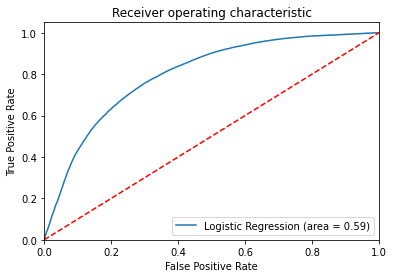

In [17]:
#Create ROC curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(LR_Xtest))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(LR_Xtest)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [18]:
#Find optimal threshold
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)

Threshold value is: 0.37173442442209376


In [19]:
#results based on optimal threshold
THRESHOLD = optimal_threshold
preds = np.where(logreg.predict_proba(LR_Xtest)[:,1] > THRESHOLD, 1, 0)

tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
(tn, fp, fn, tp)

(37703, 16087, 11770, 36395)

In [20]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

         0.0       0.76      0.70      0.73     53790
         1.0       0.69      0.76      0.72     48165

    accuracy                           0.73    101955
   macro avg       0.73      0.73      0.73    101955
weighted avg       0.73      0.73      0.73    101955



### 2. XGBoost: an example of Boosting algorithm

Next, we tried a gradiant boosting machine learning method called XGBoost (extreme Gradient Boosting), which is an implementation of gradiant boosted decision trees. Boosting is an ensemble method, where models are added consecutively to improve accuracy of the previous ones, and gradient boosting uses gradient descent algorithm to minimise the loss when adding new models. 

XGBoost is popular as it provides results with high accuracy in both classification and regression problems. Before implementing XGBoost, we will tune 4 of its parameters:
1. *n_estimators*: number of estimators when boosting is terminated. 
2. *max_depth*: maximum depth of a tree. Higher value can make the tree overfit
3. *gamma*: minimum loss reduction required to make partition on a leaf node of the tree. the higher value of gamma, the more conservative the algorithm will be
4. *scale_pos_weight*: parameter that control the balance for positive and negative weights. Since our data is slightly imbalance, we will tune a few values to see if it makes a big difference to our results

To tune these parameters, we will use *GridSearchCV()* which performs exhaustive search over specified parameter values for a model. It works by cross-validating grid-search over parameter grid.

In [21]:
#split to X and y (target variable)
X_train = train.drop(["Item_Bought_flag", "Session ID", "Item ID"], axis=1)
y_train = train["Item_Bought_flag"]
#split for test data
X_test = test.drop(["Item_Bought_flag", "Session ID", "Item ID"], axis=1)
y_test = test["Item_Bought_flag"]

In [22]:
#tuning number of estimators
param_test = {'n_estimators': range(1,100,4)}
gsearch1 = GridSearchCV(estimator = XGBClassifier(objective='binary:logistic', learning_rate=0.2, use_label_encoder =False, eval_metric = 'auc'), 
                   param_grid = param_test, scoring='roc_auc', n_jobs=-1, cv=5)
gsearch1.fit(X_train, y_train)
gsearch1.best_params_

{'n_estimators': 85}

In [23]:
#tuning maximum tree depth
param_test2 = {'max_depth':range(1,10,2)}
gsearch2 = GridSearchCV(estimator = XGBClassifier(objective='binary:logistic', n_estimators = gsearch1.best_params_['n_estimators'], learning_rate = 0.2, use_label_encoder =False, eval_metric = 'auc'), 
                        param_grid = param_test2, scoring='roc_auc', n_jobs=-1, cv=5)

gsearch2.fit(X_train, y_train)
gsearch2.best_params_

{'max_depth': 7}

In [24]:
#tuning gamma parameter
param_test3 = {'gamma': [i/10.0 for i in range(0,5)]} 
gsearch3 = GridSearchCV(estimator = XGBClassifier(objective='binary:logistic', n_estimators = gsearch1.best_params_['n_estimators'], learning_rate = 0.2, use_label_encoder =False, eval_metric = 'auc',
                                                 max_depth = gsearch2.best_params_['max_depth']), 
                                                 param_grid = param_test3, scoring='roc_auc', n_jobs=-1, cv=5)

gsearch3.fit(X_train, y_train)
gsearch3.best_params_

{'gamma': 0.1}

In [25]:
#tuning scale_pos_weight because data is imbalanced
param_test4 = {'scale_pos_weight': range(1,10,2)} ## Imbalance ratio of approx 1 to 1.14, so we iterate through a few weights
gsearch4 = GridSearchCV(estimator = XGBClassifier(objective='binary:logistic', n_estimators = gsearch1.best_params_['n_estimators'], learning_rate = 0.2, use_label_encoder =False, eval_metric = 'auc',
                                                 max_depth = gsearch2.best_params_['max_depth'], gamma = gsearch3.best_params_['gamma']),
                                                 param_grid = param_test4, scoring='roc_auc', n_jobs=-1, cv=5)

gsearch4.fit(X_train, y_train)
gsearch4.best_params_

{'scale_pos_weight': 1}

We will fit the final model using the optimised parameters we have found above.

In [57]:
#Final model
XGB_model = XGBClassifier(objective='binary:logistic', n_estimators = gsearch1.best_params_['n_estimators'], max_depth = gsearch2.best_params_['max_depth'],
                    gamma = gsearch3.best_params_['gamma'], scale_pos_weight = gsearch4.best_params_['scale_pos_weight'], n_jobs=-1, learning_rate = 0.2, use_label_encoder =False, eval_metric = 'auc')

XGB_model.fit(X_train, y_train)
XGB_model_predict = XGB_model.predict(X_test)

In [58]:
XGB_model

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='auc',
              gamma=0.1, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.2, max_delta_step=0,
              max_depth=7, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=85, n_jobs=-1,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

In [59]:
print(classification_report(y_test, XGB_model_predict))
tn, fp, fn, tp = confusion_matrix(y_test, XGB_model_predict).ravel()
print((tn, fp, fn, tp), '\n')

              precision    recall  f1-score   support

         0.0       0.78      0.83      0.80    221230
         1.0       0.78      0.72      0.75    186589

    accuracy                           0.78    407819
   macro avg       0.78      0.77      0.77    407819
weighted avg       0.78      0.78      0.78    407819

(182769, 38461, 52455, 134134) 



### 3. Support Vector Machine (SVM)

Here, we tried a non-probabilistic classifier called Support Vector Machine (SVM). This method is effective in high dimensional space and can control overfitting using its regularisation term. Additionally, it can use different kernel tricks, like polynomial or radial basis function, to transform non-linear problems to linearly separable cases. 

*SVC()* from sklearn.svm package only works well for dataset with tens of thousands observations. Since our sample has over 100,000 observations, we will need to use *SGDClassifier()* or *LinearSVC()* instead to implement SVM. Here, we will also explore different kernel approximations: linear, Radial Basis Function, and polynomial.

We will tune 3 parameters: 
1. *loss*: the loss function to be used for classification
2. *alpha*: a constant that multiplies by the regularisation term 
3. *penalty*: the penalty or regularisation term 

In [30]:
#split to X and y (target variable)
X_train = train.drop(["Item_Bought_flag", "Session ID", "Item ID"], axis=1)
y_train = train["Item_Bought_flag"]
#split for test data
X_test = test.drop(["Item_Bought_flag", "Session ID", "Item ID"], axis=1)
y_test = test["Item_Bought_flag"]

**SVM using SGDClassifier() function**

a. SVM as Linear classifier

In [31]:
scaler = StandardScaler()
SVM_Xtrain = scaler.fit_transform(X_train)
SVM_Xtest = scaler.transform(X_test)

params = {
    "loss": ["hinge", "log", "squared_hinge", "modified_huber", "perceptron"],
    "alpha": [0.0001, 0.001, 0.01, 0.1],
    "penalty": ["l2", "l1", "elasticnet"]
}
model = SGDClassifier(max_iter=100)
clf = GridSearchCV(model, param_grid=params, n_jobs=-1, cv=5,
                  scoring='roc_auc', refit=True)
clf.fit(SVM_Xtrain, y_train)
print(clf.best_estimator_)

SGDClassifier(loss='log', max_iter=100, penalty='l1')


In [32]:
y_preds = clf.predict(SVM_Xtest)
print(classification_report(y_test, y_preds))
tn, fp, fn, tp = confusion_matrix(y_test, y_preds).ravel()
print((tn, fp, fn, tp), '\n')

              precision    recall  f1-score   support

         0.0       0.79      0.77      0.78     53790
         1.0       0.75      0.77      0.76     48165

    accuracy                           0.77    101955
   macro avg       0.77      0.77      0.77    101955
weighted avg       0.77      0.77      0.77    101955

(41401, 12389, 11258, 36907) 



b. SVM using Radial Basis Function Kernel

In [33]:
params = {'gamma': [1, 0.1, 0.01, 0.001]}
rbf_feature = GridSearchCV(RBFSampler(), param_grid = params, n_jobs=-1, cv=5, scoring='explained_variance')
rbf_feature.fit(X_train)
SVM_Xtrain = rbf_feature.transform(X_train)
SVM_Xtest = rbf_feature.transform(X_test)

params = {
    "loss": ["hinge", "log", "squared_hinge", "modified_huber", "perceptron"],
    "alpha": [0.0001, 0.001, 0.01, 0.1],
    "penalty": ["l2", "l1", "elasticnet"]
}
model = SGDClassifier(max_iter=100)
clf = GridSearchCV(model, param_grid=params, n_jobs=-1, cv=5,
                  scoring='roc_auc', refit=True)
clf.fit(SVM_Xtrain, y_train)
print(clf.best_estimator_)

C:\Users\lilya\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan]
  warnings.warn(


SGDClassifier(alpha=0.001, loss='modified_huber', max_iter=100)


In [34]:
y_preds = clf.predict(SVM_Xtest)
print(classification_report(y_test, y_preds))
tn, fp, fn, tp = confusion_matrix(y_test, y_preds).ravel()
print((tn, fp, fn, tp), '\n')

              precision    recall  f1-score   support

         0.0       0.53      1.00      0.69     53790
         1.0       0.51      0.00      0.00     48165

    accuracy                           0.53    101955
   macro avg       0.52      0.50      0.35    101955
weighted avg       0.52      0.53      0.36    101955

(53767, 23, 48141, 24) 



c. SVM using Polynomial Kernel

In [35]:
poly_feature = PolynomialCountSketch(degree = 2, n_components = 200) #optimal n_components = 10*n_features
SVM_Xtrain = poly_feature.fit_transform(X_train)
SVM_Xtest = poly_feature.transform(X_test)

params = {
    "loss": ["hinge", "log", "squared_hinge", "modified_huber", "perceptron"],
    "alpha": [0.0001, 0.001, 0.01, 0.1],
    "penalty": ["l2", "l1", "elasticnet"]
}
model = SGDClassifier(max_iter=100)
clf = GridSearchCV(model, param_grid=params, n_jobs=-1, cv=5,
                  scoring='roc_auc', refit=True)
clf.fit(SVM_Xtrain, y_train)
print(clf.best_estimator_)

SGDClassifier(alpha=0.1, loss='modified_huber', max_iter=100, penalty='l1')


C:\Users\lilya\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:574: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


In [36]:
y_preds = clf.predict(SVM_Xtest)
print(classification_report(y_test, y_preds))
tn, fp, fn, tp = confusion_matrix(y_test, y_preds).ravel()
print((tn, fp, fn, tp), '\n')

              precision    recall  f1-score   support

         0.0       0.68      0.78      0.72     53790
         1.0       0.70      0.58      0.64     48165

    accuracy                           0.69    101955
   macro avg       0.69      0.68      0.68    101955
weighted avg       0.69      0.69      0.68    101955

(41751, 12039, 20057, 28108) 



**SVM using LinearSVC() function**

As SVM with the radial basis function did not give good results as observed earlier when implementing with *SGDClassifier()*, we will not implement it here and only use linear and polynomial kernel instead.

a. SVM as Linear Classifier

In [37]:
scaler = StandardScaler()
SVM_Xtrain = scaler.fit_transform(X_train)
SVM_Xtest = scaler.transform(X_test)

params = {
    "loss": ["hinge", "log", "squared_hinge", "modified_huber", "perceptron"],
    "C": [0.1, 1, 10, 100, 500, 1000],
    "penalty": ["l2", "l1", "elasticnet"]
}
model = LinearSVC(dual=False)
clf = GridSearchCV(model, param_grid=params, n_jobs=-1, cv=5, scoring='roc_auc', refit=True)
clf.fit(SVM_Xtrain, y_train)
print(clf.best_estimator_)

C:\Users\lilya\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan        nan        nan
 0.8395803  0.83953285        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan 0.83958961 0.83954077        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
 0.83959054 0.839535          nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan 0.83959055 0.8395418         nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
 0.83959057 0.83953952        nan        nan        nan        nan
        nan        nan        nan        nan        n

LinearSVC(C=1000, dual=False)


In [38]:
y_preds = clf.predict(SVM_Xtest)
print(classification_report(y_test, y_preds))
tn, fp, fn, tp = confusion_matrix(y_test, y_preds).ravel()
print((tn, fp, fn, tp), '\n')

              precision    recall  f1-score   support

         0.0       0.79      0.76      0.78     53790
         1.0       0.74      0.77      0.76     48165

    accuracy                           0.77    101955
   macro avg       0.77      0.77      0.77    101955
weighted avg       0.77      0.77      0.77    101955

(41002, 12788, 10852, 37313) 



b. SVM using Polynomial Kernel

In [39]:
poly_feature = PolynomialCountSketch(degree = 2, n_components = 200) #optimal n_components = 10*n_features
SVM_Xtrain = poly_feature.fit_transform(X_train)
SVM_Xtest = poly_feature.transform(X_test)

params = {
    "loss": ["hinge", "log", "squared_hinge", "modified_huber", "perceptron"],
    "C": [0.1, 1, 10, 100, 500, 1000],
    "penalty": ["l2", "l1", "elasticnet"]
}
model = LinearSVC(dual=False)
clf = GridSearchCV(model, param_grid=params, n_jobs=-1, cv=5, scoring='roc_auc', refit=True)
clf.fit(SVM_Xtrain, y_train)
print(clf.best_estimator_)

C:\Users\lilya\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan        nan        nan        nan        nan
 0.8247355  0.84860079        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan 0.82291971 0.84861615        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
 0.82041339 0.84860513        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan 0.82424275 0.84861437        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
 0.82341789 0.84861156        nan        nan        nan        nan
        nan        nan        nan        nan        n

LinearSVC(C=1000, dual=False, penalty='l1')


C:\Users\lilya\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [40]:
y_preds = clf.predict(SVM_Xtest)
print(classification_report(y_test, y_preds))
tn, fp, fn, tp = confusion_matrix(y_test, y_preds).ravel()
print((tn, fp, fn, tp), '\n')

              precision    recall  f1-score   support

         0.0       0.80      0.77      0.78     53790
         1.0       0.75      0.78      0.77     48165

    accuracy                           0.78    101955
   macro avg       0.78      0.78      0.78    101955
weighted avg       0.78      0.78      0.78    101955

(41528, 12262, 10523, 37642) 



### 4. Neural Networks

Here, we tried Neural Networks method, which is superior at capturing complex relationships between varibles by searching through different models in its black box to find patterns. In its black box, there can be one or more linear or non-linear hidden layers. 

We need to normalise the data before running neural networks as it is sensitive to feature scaling. We also specify that it will train using 2 hidden layers as 1 or 2 should give a decent performance for most problems, and 20 as number of neurons as we have 20 features in our dataset. 

In [41]:
#split to X and y (target variable)
X_train = train.drop(["Item_Bought_flag", "Session ID", "Item ID"], axis=1)
y_train = train["Item_Bought_flag"]
#split for test data
X_test = test.drop(["Item_Bought_flag", "Session ID", "Item ID"], axis=1)
y_test = test["Item_Bought_flag"]

In [42]:
scaler = StandardScaler()
NN_Xtrain = scaler.fit_transform(X_train)
NN_Xtest = scaler.transform(X_test)

params = {'activation': ['identity', 'logistic', 'tanh', 'relu'],
          'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
model = MLPClassifier(hidden_layer_sizes = (20, 20), max_iter = 100, solver='adam') 
#2 hidden layers and 'adam' optimizer works well for large dataset
mlp = GridSearchCV(model, param_grid = params, n_jobs=-1, cv=5, scoring='roc_auc', refit=True)
mlp.fit(NN_Xtrain, y_train)
print(mlp.best_estimator_) 

MLPClassifier(alpha=0.01, hidden_layer_sizes=(20, 20), max_iter=100)


In [43]:
y_preds = mlp.predict(NN_Xtest)
print(classification_report(y_test, y_preds))
tn, fp, fn, tp = confusion_matrix(y_test, y_preds).ravel()
print((tn, fp, fn, tp), '\n')

              precision    recall  f1-score   support

         0.0       0.81      0.78      0.79     53790
         1.0       0.76      0.79      0.78     48165

    accuracy                           0.79    101955
   macro avg       0.79      0.79      0.79    101955
weighted avg       0.79      0.79      0.79    101955

(42012, 11778, 10085, 38080) 



### 5. Random Forest: an example of Bagging algorithm

Random Forest is a ensemble method called bagging, where it constructs multiple trees using random features on a sub-set of data while training and the average prediction of individual trees is returned. It is superior to decision trees as it can control overfitting and improve predictive accuracy. It also works well on large dataset.

To implement Random Forest, we will tune 2 of its parameters: 
1. *n_estimators*: number of tress in the forest  
2. *max_features*: number of features to consider when looking for the best split

In [44]:
#split to X and y (target variable)
X_train = train.drop(["Item_Bought_flag", "Session ID", "Item ID"], axis=1)
y_train = train["Item_Bought_flag"]
#split for test data
X_test = test.drop(["Item_Bought_flag", "Session ID", "Item ID"], axis=1)
y_test = test["Item_Bought_flag"]

In [45]:
params = {'n_estimators': range(1, 200, 20),
         'max_features': ['auto', 'log2']}
model = RandomForestClassifier(n_jobs=-1)
rfc = GridSearchCV(model, param_grid = params, n_jobs=-1, cv=5, scoring='roc_auc', refit=True)
rfc.fit(X_train, y_train)
print(rfc.best_estimator_) 

RandomForestClassifier(n_estimators=181, n_jobs=-1)


In [46]:
y_preds = rfc.predict(X_test)
print(classification_report(y_test, y_preds))
tn, fp, fn, tp = confusion_matrix(y_test, y_preds).ravel()
print((tn, fp, fn, tp), '\n')

              precision    recall  f1-score   support

         0.0       0.80      0.78      0.79     53790
         1.0       0.76      0.78      0.77     48165

    accuracy                           0.78    101955
   macro avg       0.78      0.78      0.78    101955
weighted avg       0.78      0.78      0.78    101955

(41980, 11810, 10729, 37436) 



<ipython-input-86-e6343e7950ef>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ml.sort_values('importance', inplace=True)


<BarContainer object of 17 artists>

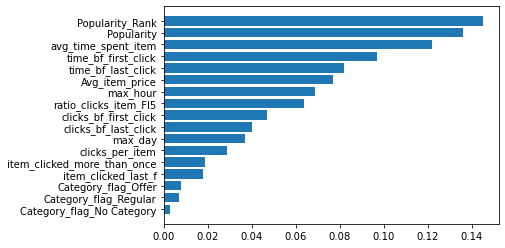

In [86]:
#Feature importance refers to techniques that assign a score to input features based on 
#how useful they are at predicting a target variable.
importances_ML = pd.DataFrame({'feature':X_train.columns,'importance':np.round(rfc.best_estimator_.feature_importances_,3)})
importances_ML = importances_ML.sort_values('importance',ascending=True)
ml = importances_ML.loc[importances_ML['importance'] > 0]
ml.sort_values('importance', inplace=True)
plt.barh(ml['feature'], ml['importance'])

### 6. CatBoost

CatBoost is a gradient boosting algorithm, whose performance is often compared with Light GBM and XGBoost. It can in some cases, performs just as well as XGBoost, at a much faster rate (as expected from the cat family). To XGBoost's credit, it is older as was developed in 2014 compared to CatBoost in 2017.

To implement CatBoost, we will tune its *iterations* parameter, which is the maximum number of trees. 

In [31]:
#split to X and y (target variable)
X_train = train.drop(["Item_Bought_flag", "Session ID", "Item ID"], axis=1)
y_train = train["Item_Bought_flag"]
#split for test data
X_test = test.drop(["Item_Bought_flag", "Session ID", "Item ID"], axis=1)
y_test = test["Item_Bought_flag"]

In [32]:
params = {'iterations': range(50, 500, 20)}

model = CatBoostClassifier(eval_metric='AUC', learning_rate = 0.2)
ctb = GridSearchCV(model, param_grid=params, cv=5, n_jobs=-1, scoring ='roc_auc', refit=True)
ctb.fit(X_train, y_train)
y_pred = ctb.predict(X_test)

C:\Users\lilya\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan 0.86370513 0.86399005 0.86428089 0.86456051
 0.86460393 0.86466814 0.8645947  0.86452117 0.8644955  0.86453506
 0.86451135 0.8645889  0.86447564 0.86437991 0.86443746 0.86444541
 0.86438553 0.86431737 0.86426436 0.86423587 0.86421141]
  warnings.warn(


0:	total: 66.8ms	remaining: 12.6s
1:	total: 149ms	remaining: 14s
2:	total: 220ms	remaining: 13.7s
3:	total: 289ms	remaining: 13.4s
4:	total: 358ms	remaining: 13.2s
5:	total: 434ms	remaining: 13.3s
6:	total: 502ms	remaining: 13.1s
7:	total: 575ms	remaining: 13.1s
8:	total: 643ms	remaining: 12.9s
9:	total: 714ms	remaining: 12.9s
10:	total: 784ms	remaining: 12.8s
11:	total: 857ms	remaining: 12.7s
12:	total: 926ms	remaining: 12.6s
13:	total: 996ms	remaining: 12.5s
14:	total: 1.06s	remaining: 12.4s
15:	total: 1.13s	remaining: 12.3s
16:	total: 1.2s	remaining: 12.2s
17:	total: 1.27s	remaining: 12.1s
18:	total: 1.34s	remaining: 12.1s
19:	total: 1.43s	remaining: 12.1s
20:	total: 1.5s	remaining: 12.1s
21:	total: 1.58s	remaining: 12.1s
22:	total: 1.65s	remaining: 12s
23:	total: 1.72s	remaining: 11.9s
24:	total: 1.8s	remaining: 11.9s
25:	total: 1.88s	remaining: 11.9s
26:	total: 1.95s	remaining: 11.8s
27:	total: 2.02s	remaining: 11.7s
28:	total: 2.09s	remaining: 11.6s
29:	total: 2.15s	remaining: 11

In [33]:
print(ctb.best_estimator_.get_all_params())

{'nan_mode': 'Min', 'eval_metric': 'AUC', 'iterations': 190, 'sampling_frequency': 'PerTree', 'leaf_estimation_method': 'Newton', 'grow_policy': 'SymmetricTree', 'penalties_coefficient': 1, 'boosting_type': 'Plain', 'model_shrink_mode': 'Constant', 'feature_border_type': 'GreedyLogSum', 'bayesian_matrix_reg': 0.10000000149011612, 'l2_leaf_reg': 3, 'random_strength': 1, 'rsm': 1, 'boost_from_average': False, 'model_size_reg': 0.5, 'pool_metainfo_options': {'tags': {}}, 'subsample': 0.800000011920929, 'use_best_model': False, 'class_names': [0, 1], 'random_seed': 0, 'depth': 6, 'posterior_sampling': False, 'border_count': 254, 'classes_count': 0, 'auto_class_weights': 'None', 'sparse_features_conflict_fraction': 0, 'leaf_estimation_backtracking': 'AnyImprovement', 'best_model_min_trees': 1, 'model_shrink_rate': 0, 'min_data_in_leaf': 1, 'loss_function': 'Logloss', 'learning_rate': 0.20000000298023224, 'score_function': 'Cosine', 'task_type': 'CPU', 'leaf_estimation_iterations': 10, 'boot

In [34]:
print(classification_report(y_test, y_pred), '\n')

              precision    recall  f1-score   support

         0.0       0.81      0.78      0.80     53790
         1.0       0.77      0.79      0.78     48165

    accuracy                           0.79    101955
   macro avg       0.79      0.79      0.79    101955
weighted avg       0.79      0.79      0.79    101955
 



### 7. Light GBM

LightGBM is a gradient boosting method developed by Microsoft. It differs from XGBoost in which it construct trees using Gradient-Based One-Sided Sampling, which is a novel approach to sampling method and as it brings down the complexity in training the decision trees, it subsequently makes the algorithm much faster to run. 

To implement LightGBM, we will tune 2 of its parameters:
1. *n_estimators*: number of boosted trees to fit
2. *boosting_type*: boosting types
    * 'gbdt': gradient boosting decision tree   
    * 'dart': dropouts meet multiple additive regression trees    
    * 'goss': gradient-based one-side sampling  
    * 'rf': random forest

In [45]:
#split to X and y (target variable)
X_train = train.drop(["Item_Bought_flag", "Session ID", "Item ID"], axis=1)
y_train = train["Item_Bought_flag"]
#split for test data
X_test = test.drop(["Item_Bought_flag", "Session ID", "Item ID"], axis=1)
y_test = test["Item_Bought_flag"]

In [46]:
params = {'n_estimators': range(50, 500, 50),
         'boosting_type':['gbdt', 'dart', 'goss', 'rf']}

model = LGBMClassifier(objective = 'binary', learning_rate = 0.2)
lgbm = GridSearchCV(model, param_grid=params, cv=5, n_jobs=-1, scoring ='roc_auc', refit=True)
lgbm.fit(X_train, y_train)
y_pred = lgbm.predict(X_test)

C:\Users\lilya\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.86322246 0.86357732 0.86346266 0.86327233 0.8630912  0.86288948
 0.86252962 0.86227351 0.86200519 0.86251685 0.86366749 0.86422941
 0.86478314 0.86510818 0.86516836 0.86522494 0.86524194 0.86517734
 0.86016467 0.85786286 0.85647379 0.85528183 0.85237256 0.84855147
 0.84662258 0.84301695 0.82717411        nan        nan        nan
        nan        nan        nan        nan        nan        nan]
  warnings.warn(


In [47]:
print(lgbm.best_estimator_)

LGBMClassifier(boosting_type='dart', learning_rate=0.2, n_estimators=400,
               objective='binary')


In [48]:
print(classification_report(y_test, y_pred), '\n')

              precision    recall  f1-score   support

         0.0       0.81      0.78      0.79     53790
         1.0       0.76      0.79      0.78     48165

    accuracy                           0.79    101955
   macro avg       0.79      0.79      0.79    101955
weighted avg       0.79      0.79      0.79    101955
 



### 8. Stacking Classifier

Stacking is an ensemble method that combines multiple base classification models predictions, then it uses a blending model to combine the prediction of the base models. Stacking can harness the capabilities of different models and improve performance than any single model in the ensemble. The base models can be complex and diverse, while the blending model is often simple as it only needs to provide a smooth interpretation of the predictions output by the base models. 

Here, we tried different combinations of models to see if we can improve their performances. Light GBM, Neural Networks, and CatBoost have highest performance from the results earlier. While SVM was chosen as it is a slightly different machine learning method that can provide more diversity to the ensemble. 
1. Light GBM, Neural Networks, and CatBoost
2. SVM, Neural Networks, and CatBoost
3. Light GBM, SVM, Neural Networks, and CatBoost

In [21]:
#split to X and y (target variable)
X_train = train.drop(["Item_Bought_flag", "Session ID", "Item ID"], axis=1)
y_train = train["Item_Bought_flag"]
#split for test data
X_test = test.drop(["Item_Bought_flag", "Session ID", "Item ID"], axis=1)
y_test = test["Item_Bought_flag"]

#### 1. Light GBM, Neural Networks, and CatBoost

In [9]:
estimators = [('lgbm', LGBMClassifier(objective='binary', n_estimators=400, learning_rate=0.2, boosting_type='dart')),
             ('nn', make_pipeline(StandardScaler(), 
                                  MLPClassifier(alpha=0.01, hidden_layer_sizes=(20, 20), max_iter=100))),
             ('ctb', CatBoostClassifier(iterations=190, eval_metric='AUC', learning_rate = 0.2))]
clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(), cv=5, n_jobs=-1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.81      0.78      0.80     53790
         1.0       0.77      0.79      0.78     48165

    accuracy                           0.79    101955
   macro avg       0.79      0.79      0.79    101955
weighted avg       0.79      0.79      0.79    101955



#### 2. SVM, Neural Networks, and CatBoost

In [12]:
estimators = [('svm', make_pipeline(StandardScaler(), LinearSVC(C=1000, dual=False, penalty='l1'))),
             ('nn', make_pipeline(StandardScaler(), 
                                  MLPClassifier(alpha=0.01, hidden_layer_sizes=(20, 20), max_iter=100))),
             ('ctb', CatBoostClassifier(iterations=190, eval_metric='AUC', learning_rate = 0.2))]
clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(), cv=5, n_jobs=-1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.81      0.79      0.80     53790
         1.0       0.77      0.79      0.78     48165

    accuracy                           0.79    101955
   macro avg       0.79      0.79      0.79    101955
weighted avg       0.79      0.79      0.79    101955



#### 3. Light GBM, SVM, Neural Networks, and CatBoost

In [22]:
estimators = [('lgbm', LGBMClassifier(objective='binary', n_estimators=400, learning_rate=0.2, boosting_type='dart')),
              ('svm', make_pipeline(StandardScaler(), LinearSVC(C=1000, dual=False, penalty='l1'))),
             ('nn', make_pipeline(StandardScaler(), 
                                  MLPClassifier(alpha=0.01, hidden_layer_sizes=(20, 20), max_iter=100))),
             ('ctb', CatBoostClassifier(iterations=190, eval_metric='AUC', learning_rate = 0.2))]
clf = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression(), cv=5, n_jobs=-1)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.81      0.79      0.80     53790
         1.0       0.77      0.79      0.78     48165

    accuracy                           0.79    101955
   macro avg       0.79      0.79      0.79    101955
weighted avg       0.79      0.79      0.79    101955



### 9. AdaBoost

AdaBoost is another boosting ensemble method, which was developed for classification problems. It fits copies of classifier on the same dataset but increases the weight of mis-classified data points so that the next classifier will pay extra attention to them. It improves accuracy by combining weak learners. One advantage of AdaBoost is that we can specify a base machine learning method from which the boosted ensemble is built, which can help improve the performance of the originial method.

Here, we tried to fit CatBoost as base estimator to see if we can improve its performance. 

In [23]:
ctb = CatBoostClassifier(iterations=190, eval_metric='AUC', learning_rate = 0.2)
adc = AdaBoostClassifier(base_estimator=ctb, n_estimators=100)
adc.fit(X_train, y_train)
y_pred = adc.predict(X_test)

0:	total: 43.4ms	remaining: 8.21s
1:	total: 87.2ms	remaining: 8.2s
2:	total: 136ms	remaining: 8.5s
3:	total: 183ms	remaining: 8.53s
4:	total: 227ms	remaining: 8.4s
5:	total: 278ms	remaining: 8.52s
6:	total: 321ms	remaining: 8.38s
7:	total: 365ms	remaining: 8.3s
8:	total: 412ms	remaining: 8.28s
9:	total: 464ms	remaining: 8.35s
10:	total: 513ms	remaining: 8.35s
11:	total: 567ms	remaining: 8.41s
12:	total: 617ms	remaining: 8.4s
13:	total: 677ms	remaining: 8.52s
14:	total: 731ms	remaining: 8.52s
15:	total: 784ms	remaining: 8.52s
16:	total: 835ms	remaining: 8.49s
17:	total: 891ms	remaining: 8.51s
18:	total: 937ms	remaining: 8.43s
19:	total: 986ms	remaining: 8.38s
20:	total: 1.03s	remaining: 8.3s
21:	total: 1.08s	remaining: 8.27s
22:	total: 1.13s	remaining: 8.19s
23:	total: 1.17s	remaining: 8.11s
24:	total: 1.22s	remaining: 8.04s
25:	total: 1.27s	remaining: 8.01s
26:	total: 1.32s	remaining: 7.95s
27:	total: 1.36s	remaining: 7.9s
28:	total: 1.42s	remaining: 7.89s
29:	total: 1.48s	remaining: 7

51:	total: 2.6s	remaining: 6.9s
52:	total: 2.65s	remaining: 6.85s
53:	total: 2.7s	remaining: 6.8s
54:	total: 2.75s	remaining: 6.74s
55:	total: 2.79s	remaining: 6.67s
56:	total: 2.84s	remaining: 6.63s
57:	total: 2.89s	remaining: 6.57s
58:	total: 2.94s	remaining: 6.53s
59:	total: 2.99s	remaining: 6.49s
60:	total: 3.05s	remaining: 6.44s
61:	total: 3.1s	remaining: 6.39s
62:	total: 3.14s	remaining: 6.33s
63:	total: 3.19s	remaining: 6.28s
64:	total: 3.24s	remaining: 6.23s
65:	total: 3.28s	remaining: 6.17s
66:	total: 3.33s	remaining: 6.11s
67:	total: 3.37s	remaining: 6.05s
68:	total: 3.42s	remaining: 5.99s
69:	total: 3.46s	remaining: 5.93s
70:	total: 3.51s	remaining: 5.88s
71:	total: 3.55s	remaining: 5.82s
72:	total: 3.6s	remaining: 5.77s
73:	total: 3.65s	remaining: 5.72s
74:	total: 3.7s	remaining: 5.67s
75:	total: 3.75s	remaining: 5.63s
76:	total: 3.81s	remaining: 5.58s
77:	total: 3.86s	remaining: 5.54s
78:	total: 3.9s	remaining: 5.48s
79:	total: 3.95s	remaining: 5.43s
80:	total: 3.99s	remai

103:	total: 6.94s	remaining: 5.74s
104:	total: 7s	remaining: 5.67s
105:	total: 7.06s	remaining: 5.59s
106:	total: 7.12s	remaining: 5.52s
107:	total: 7.19s	remaining: 5.46s
108:	total: 7.25s	remaining: 5.38s
109:	total: 7.31s	remaining: 5.31s
110:	total: 7.36s	remaining: 5.24s
111:	total: 7.42s	remaining: 5.17s
112:	total: 7.48s	remaining: 5.1s
113:	total: 7.54s	remaining: 5.03s
114:	total: 7.6s	remaining: 4.96s
115:	total: 7.67s	remaining: 4.89s
116:	total: 7.74s	remaining: 4.83s
117:	total: 7.79s	remaining: 4.75s
118:	total: 7.85s	remaining: 4.68s
119:	total: 7.91s	remaining: 4.62s
120:	total: 7.98s	remaining: 4.55s
121:	total: 8.04s	remaining: 4.48s
122:	total: 8.11s	remaining: 4.42s
123:	total: 8.19s	remaining: 4.36s
124:	total: 8.27s	remaining: 4.3s
125:	total: 8.34s	remaining: 4.24s
126:	total: 8.41s	remaining: 4.17s
127:	total: 8.49s	remaining: 4.11s
128:	total: 8.57s	remaining: 4.05s
129:	total: 8.64s	remaining: 3.99s
130:	total: 8.71s	remaining: 3.92s
131:	total: 8.78s	remainin

153:	total: 9.7s	remaining: 2.27s
154:	total: 9.76s	remaining: 2.2s
155:	total: 9.82s	remaining: 2.14s
156:	total: 9.88s	remaining: 2.08s
157:	total: 9.94s	remaining: 2.01s
158:	total: 10s	remaining: 1.95s
159:	total: 10.1s	remaining: 1.89s
160:	total: 10.1s	remaining: 1.82s
161:	total: 10.2s	remaining: 1.76s
162:	total: 10.3s	remaining: 1.7s
163:	total: 10.3s	remaining: 1.64s
164:	total: 10.4s	remaining: 1.57s
165:	total: 10.4s	remaining: 1.51s
166:	total: 10.5s	remaining: 1.45s
167:	total: 10.6s	remaining: 1.38s
168:	total: 10.6s	remaining: 1.32s
169:	total: 10.7s	remaining: 1.26s
170:	total: 10.8s	remaining: 1.2s
171:	total: 10.8s	remaining: 1.13s
172:	total: 10.9s	remaining: 1.07s
173:	total: 10.9s	remaining: 1s
174:	total: 11s	remaining: 943ms
175:	total: 11.1s	remaining: 880ms
176:	total: 11.1s	remaining: 818ms
177:	total: 11.2s	remaining: 756ms
178:	total: 11.3s	remaining: 693ms
179:	total: 11.3s	remaining: 630ms
180:	total: 11.4s	remaining: 567ms
181:	total: 11.5s	remaining: 50

14:	total: 947ms	remaining: 11.1s
15:	total: 1.02s	remaining: 11.1s
16:	total: 1.09s	remaining: 11.1s
17:	total: 1.15s	remaining: 11s
18:	total: 1.21s	remaining: 10.9s
19:	total: 1.27s	remaining: 10.8s
20:	total: 1.34s	remaining: 10.8s
21:	total: 1.4s	remaining: 10.7s
22:	total: 1.46s	remaining: 10.6s
23:	total: 1.52s	remaining: 10.5s
24:	total: 1.58s	remaining: 10.5s
25:	total: 1.64s	remaining: 10.4s
26:	total: 1.7s	remaining: 10.3s
27:	total: 1.78s	remaining: 10.3s
28:	total: 1.83s	remaining: 10.2s
29:	total: 1.89s	remaining: 10.1s
30:	total: 1.96s	remaining: 10.1s
31:	total: 2.02s	remaining: 9.95s
32:	total: 2.07s	remaining: 9.87s
33:	total: 2.13s	remaining: 9.79s
34:	total: 2.19s	remaining: 9.7s
35:	total: 2.25s	remaining: 9.62s
36:	total: 2.31s	remaining: 9.54s
37:	total: 2.37s	remaining: 9.48s
38:	total: 2.43s	remaining: 9.4s
39:	total: 2.49s	remaining: 9.33s
40:	total: 2.55s	remaining: 9.25s
41:	total: 2.61s	remaining: 9.19s
42:	total: 2.66s	remaining: 9.11s
43:	total: 2.72s	rem

65:	total: 4.53s	remaining: 8.5s
66:	total: 4.59s	remaining: 8.43s
67:	total: 4.66s	remaining: 8.35s
68:	total: 4.72s	remaining: 8.28s
69:	total: 4.78s	remaining: 8.2s
70:	total: 4.84s	remaining: 8.11s
71:	total: 4.91s	remaining: 8.04s
72:	total: 4.98s	remaining: 7.98s
73:	total: 5.05s	remaining: 7.92s
74:	total: 5.13s	remaining: 7.86s
75:	total: 5.19s	remaining: 7.79s
76:	total: 5.26s	remaining: 7.72s
77:	total: 5.32s	remaining: 7.64s
78:	total: 5.39s	remaining: 7.57s
79:	total: 5.46s	remaining: 7.5s
80:	total: 5.52s	remaining: 7.43s
81:	total: 5.58s	remaining: 7.35s
82:	total: 5.64s	remaining: 7.28s
83:	total: 5.7s	remaining: 7.2s
84:	total: 5.76s	remaining: 7.12s
85:	total: 5.82s	remaining: 7.04s
86:	total: 5.88s	remaining: 6.96s
87:	total: 5.95s	remaining: 6.89s
88:	total: 6.01s	remaining: 6.82s
89:	total: 6.08s	remaining: 6.76s
90:	total: 6.16s	remaining: 6.7s
91:	total: 6.23s	remaining: 6.63s
92:	total: 6.29s	remaining: 6.56s
93:	total: 6.34s	remaining: 6.48s
94:	total: 6.4s	rema

117:	total: 7.87s	remaining: 4.8s
118:	total: 7.93s	remaining: 4.73s
119:	total: 8.01s	remaining: 4.67s
120:	total: 8.08s	remaining: 4.61s
121:	total: 8.16s	remaining: 4.55s
122:	total: 8.23s	remaining: 4.48s
123:	total: 8.3s	remaining: 4.42s
124:	total: 8.36s	remaining: 4.35s
125:	total: 8.42s	remaining: 4.28s
126:	total: 8.49s	remaining: 4.21s
127:	total: 8.55s	remaining: 4.14s
128:	total: 8.62s	remaining: 4.08s
129:	total: 8.68s	remaining: 4s
130:	total: 8.75s	remaining: 3.94s
131:	total: 8.83s	remaining: 3.88s
132:	total: 8.93s	remaining: 3.83s
133:	total: 9s	remaining: 3.76s
134:	total: 9.08s	remaining: 3.7s
135:	total: 9.15s	remaining: 3.63s
136:	total: 9.23s	remaining: 3.57s
137:	total: 9.32s	remaining: 3.51s
138:	total: 9.39s	remaining: 3.44s
139:	total: 9.46s	remaining: 3.38s
140:	total: 9.54s	remaining: 3.31s
141:	total: 9.61s	remaining: 3.25s
142:	total: 9.68s	remaining: 3.18s
143:	total: 9.74s	remaining: 3.11s
144:	total: 9.81s	remaining: 3.04s
145:	total: 9.89s	remaining: 

166:	total: 10.4s	remaining: 1.44s
167:	total: 10.5s	remaining: 1.38s
168:	total: 10.6s	remaining: 1.31s
169:	total: 10.7s	remaining: 1.25s
170:	total: 10.7s	remaining: 1.19s
171:	total: 10.8s	remaining: 1.13s
172:	total: 10.9s	remaining: 1.07s
173:	total: 10.9s	remaining: 1s
174:	total: 11s	remaining: 943ms
175:	total: 11.1s	remaining: 879ms
176:	total: 11.1s	remaining: 816ms
177:	total: 11.2s	remaining: 753ms
178:	total: 11.2s	remaining: 690ms
179:	total: 11.3s	remaining: 628ms
180:	total: 11.4s	remaining: 566ms
181:	total: 11.4s	remaining: 503ms
182:	total: 11.5s	remaining: 440ms
183:	total: 11.6s	remaining: 377ms
184:	total: 11.6s	remaining: 314ms
185:	total: 11.7s	remaining: 251ms
186:	total: 11.7s	remaining: 188ms
187:	total: 11.8s	remaining: 126ms
188:	total: 11.9s	remaining: 62.8ms
189:	total: 11.9s	remaining: 0us
0:	total: 57ms	remaining: 10.8s
1:	total: 121ms	remaining: 11.4s
2:	total: 187ms	remaining: 11.7s
3:	total: 250ms	remaining: 11.6s
4:	total: 318ms	remaining: 11.8s
5:

26:	total: 1.69s	remaining: 10.2s
27:	total: 1.75s	remaining: 10.1s
28:	total: 1.82s	remaining: 10.1s
29:	total: 1.88s	remaining: 10s
30:	total: 1.95s	remaining: 9.99s
31:	total: 2.01s	remaining: 9.94s
32:	total: 2.07s	remaining: 9.86s
33:	total: 2.13s	remaining: 9.79s
34:	total: 2.21s	remaining: 9.79s
35:	total: 2.3s	remaining: 9.84s
36:	total: 2.39s	remaining: 9.88s
37:	total: 2.48s	remaining: 9.91s
38:	total: 2.56s	remaining: 9.9s
39:	total: 2.63s	remaining: 9.87s
40:	total: 2.72s	remaining: 9.89s
41:	total: 2.79s	remaining: 9.84s
42:	total: 2.87s	remaining: 9.82s
43:	total: 2.96s	remaining: 9.84s
44:	total: 3.03s	remaining: 9.75s
45:	total: 3.09s	remaining: 9.68s
46:	total: 3.16s	remaining: 9.61s
47:	total: 3.22s	remaining: 9.53s
48:	total: 3.29s	remaining: 9.46s
49:	total: 3.35s	remaining: 9.39s
50:	total: 3.41s	remaining: 9.3s
51:	total: 3.47s	remaining: 9.22s
52:	total: 3.54s	remaining: 9.14s
53:	total: 3.6s	remaining: 9.06s
54:	total: 3.65s	remaining: 8.97s
55:	total: 3.72s	rem

78:	total: 5.34s	remaining: 7.5s
79:	total: 5.42s	remaining: 7.45s
80:	total: 5.5s	remaining: 7.4s
81:	total: 5.58s	remaining: 7.35s
82:	total: 5.66s	remaining: 7.29s
83:	total: 5.73s	remaining: 7.23s
84:	total: 5.78s	remaining: 7.14s
85:	total: 5.85s	remaining: 7.08s
86:	total: 5.92s	remaining: 7.01s
87:	total: 5.98s	remaining: 6.94s
88:	total: 6.05s	remaining: 6.87s
89:	total: 6.11s	remaining: 6.79s
90:	total: 6.17s	remaining: 6.71s
91:	total: 6.23s	remaining: 6.63s
92:	total: 6.29s	remaining: 6.56s
93:	total: 6.35s	remaining: 6.48s
94:	total: 6.41s	remaining: 6.41s
95:	total: 6.47s	remaining: 6.33s
96:	total: 6.53s	remaining: 6.26s
97:	total: 6.6s	remaining: 6.19s
98:	total: 6.66s	remaining: 6.12s
99:	total: 6.73s	remaining: 6.06s
100:	total: 6.81s	remaining: 6s
101:	total: 6.88s	remaining: 5.93s
102:	total: 6.94s	remaining: 5.86s
103:	total: 7s	remaining: 5.79s
104:	total: 7.07s	remaining: 5.72s
105:	total: 7.14s	remaining: 5.66s
106:	total: 7.2s	remaining: 5.58s
107:	total: 7.25s	

130:	total: 8.17s	remaining: 3.68s
131:	total: 8.22s	remaining: 3.61s
132:	total: 8.28s	remaining: 3.55s
133:	total: 8.35s	remaining: 3.49s
134:	total: 8.41s	remaining: 3.43s
135:	total: 8.47s	remaining: 3.36s
136:	total: 8.53s	remaining: 3.3s
137:	total: 8.6s	remaining: 3.24s
138:	total: 8.66s	remaining: 3.18s
139:	total: 8.72s	remaining: 3.11s
140:	total: 8.78s	remaining: 3.05s
141:	total: 8.85s	remaining: 2.99s
142:	total: 8.91s	remaining: 2.93s
143:	total: 8.97s	remaining: 2.87s
144:	total: 9.03s	remaining: 2.8s
145:	total: 9.09s	remaining: 2.74s
146:	total: 9.14s	remaining: 2.67s
147:	total: 9.2s	remaining: 2.61s
148:	total: 9.26s	remaining: 2.55s
149:	total: 9.32s	remaining: 2.48s
150:	total: 9.38s	remaining: 2.42s
151:	total: 9.44s	remaining: 2.36s
152:	total: 9.5s	remaining: 2.3s
153:	total: 9.56s	remaining: 2.23s
154:	total: 9.62s	remaining: 2.17s
155:	total: 9.67s	remaining: 2.11s
156:	total: 9.73s	remaining: 2.04s
157:	total: 9.79s	remaining: 1.98s
158:	total: 9.86s	remainin

182:	total: 11.8s	remaining: 451ms
183:	total: 11.9s	remaining: 387ms
184:	total: 11.9s	remaining: 322ms
185:	total: 12s	remaining: 258ms
186:	total: 12s	remaining: 193ms
187:	total: 12.1s	remaining: 129ms
188:	total: 12.2s	remaining: 64.5ms
189:	total: 12.3s	remaining: 0us
0:	total: 53.5ms	remaining: 10.1s
1:	total: 107ms	remaining: 10.1s
2:	total: 166ms	remaining: 10.4s
3:	total: 221ms	remaining: 10.3s
4:	total: 288ms	remaining: 10.6s
5:	total: 351ms	remaining: 10.8s
6:	total: 412ms	remaining: 10.8s
7:	total: 473ms	remaining: 10.8s
8:	total: 533ms	remaining: 10.7s
9:	total: 587ms	remaining: 10.6s
10:	total: 644ms	remaining: 10.5s
11:	total: 710ms	remaining: 10.5s
12:	total: 776ms	remaining: 10.6s
13:	total: 846ms	remaining: 10.6s
14:	total: 907ms	remaining: 10.6s
15:	total: 970ms	remaining: 10.6s
16:	total: 1.03s	remaining: 10.5s
17:	total: 1.1s	remaining: 10.6s
18:	total: 1.17s	remaining: 10.6s
19:	total: 1.23s	remaining: 10.5s
20:	total: 1.29s	remaining: 10.4s
21:	total: 1.36s	rema

46:	total: 3.31s	remaining: 10.1s
47:	total: 3.37s	remaining: 9.97s
48:	total: 3.43s	remaining: 9.87s
49:	total: 3.5s	remaining: 9.81s
50:	total: 3.57s	remaining: 9.72s
51:	total: 3.63s	remaining: 9.64s
52:	total: 3.71s	remaining: 9.6s
53:	total: 3.79s	remaining: 9.55s
54:	total: 3.87s	remaining: 9.49s
55:	total: 3.93s	remaining: 9.4s
56:	total: 4.01s	remaining: 9.35s
57:	total: 4.08s	remaining: 9.29s
58:	total: 4.15s	remaining: 9.22s
59:	total: 4.23s	remaining: 9.17s
60:	total: 4.3s	remaining: 9.1s
61:	total: 4.36s	remaining: 8.99s
62:	total: 4.42s	remaining: 8.9s
63:	total: 4.48s	remaining: 8.83s
64:	total: 4.55s	remaining: 8.76s
65:	total: 4.62s	remaining: 8.68s
66:	total: 4.69s	remaining: 8.61s
67:	total: 4.77s	remaining: 8.55s
68:	total: 4.84s	remaining: 8.49s
69:	total: 4.92s	remaining: 8.44s
70:	total: 5.01s	remaining: 8.39s
71:	total: 5.09s	remaining: 8.34s
72:	total: 5.16s	remaining: 8.27s
73:	total: 5.22s	remaining: 8.19s
74:	total: 5.28s	remaining: 8.1s
75:	total: 5.34s	rema

97:	total: 6.01s	remaining: 5.64s
98:	total: 6.07s	remaining: 5.58s
99:	total: 6.14s	remaining: 5.53s
100:	total: 6.2s	remaining: 5.47s
101:	total: 6.26s	remaining: 5.41s
102:	total: 6.33s	remaining: 5.34s
103:	total: 6.39s	remaining: 5.28s
104:	total: 6.45s	remaining: 5.22s
105:	total: 6.51s	remaining: 5.16s
106:	total: 6.57s	remaining: 5.09s
107:	total: 6.63s	remaining: 5.03s
108:	total: 6.68s	remaining: 4.97s
109:	total: 6.75s	remaining: 4.91s
110:	total: 6.8s	remaining: 4.84s
111:	total: 6.86s	remaining: 4.78s
112:	total: 6.92s	remaining: 4.71s
113:	total: 6.98s	remaining: 4.65s
114:	total: 7.03s	remaining: 4.58s
115:	total: 7.09s	remaining: 4.52s
116:	total: 7.16s	remaining: 4.46s
117:	total: 7.22s	remaining: 4.4s
118:	total: 7.28s	remaining: 4.34s
119:	total: 7.33s	remaining: 4.28s
120:	total: 7.4s	remaining: 4.22s
121:	total: 7.46s	remaining: 4.16s
122:	total: 7.52s	remaining: 4.09s
123:	total: 7.58s	remaining: 4.03s
124:	total: 7.64s	remaining: 3.97s
125:	total: 7.7s	remaining:

149:	total: 9.69s	remaining: 2.58s
150:	total: 9.75s	remaining: 2.52s
151:	total: 9.82s	remaining: 2.46s
152:	total: 9.9s	remaining: 2.39s
153:	total: 9.97s	remaining: 2.33s
154:	total: 10s	remaining: 2.27s
155:	total: 10.1s	remaining: 2.2s
156:	total: 10.2s	remaining: 2.14s
157:	total: 10.3s	remaining: 2.08s
158:	total: 10.3s	remaining: 2.01s
159:	total: 10.4s	remaining: 1.95s
160:	total: 10.5s	remaining: 1.88s
161:	total: 10.5s	remaining: 1.82s
162:	total: 10.6s	remaining: 1.76s
163:	total: 10.7s	remaining: 1.69s
164:	total: 10.7s	remaining: 1.63s
165:	total: 10.8s	remaining: 1.56s
166:	total: 10.9s	remaining: 1.5s
167:	total: 11s	remaining: 1.44s
168:	total: 11s	remaining: 1.37s
169:	total: 11.1s	remaining: 1.31s
170:	total: 11.2s	remaining: 1.24s
171:	total: 11.2s	remaining: 1.18s
172:	total: 11.3s	remaining: 1.11s
173:	total: 11.4s	remaining: 1.05s
174:	total: 11.5s	remaining: 982ms
175:	total: 11.5s	remaining: 917ms
176:	total: 11.6s	remaining: 852ms
177:	total: 11.7s	remaining: 

11:	total: 692ms	remaining: 10.3s
12:	total: 749ms	remaining: 10.2s
13:	total: 807ms	remaining: 10.1s
14:	total: 866ms	remaining: 10.1s
15:	total: 931ms	remaining: 10.1s
16:	total: 991ms	remaining: 10.1s
17:	total: 1.05s	remaining: 10s
18:	total: 1.11s	remaining: 9.95s
19:	total: 1.17s	remaining: 9.91s
20:	total: 1.23s	remaining: 9.86s
21:	total: 1.28s	remaining: 9.8s
22:	total: 1.35s	remaining: 9.8s
23:	total: 1.41s	remaining: 9.73s
24:	total: 1.47s	remaining: 9.73s
25:	total: 1.53s	remaining: 9.66s
26:	total: 1.59s	remaining: 9.62s
27:	total: 1.65s	remaining: 9.54s
28:	total: 1.71s	remaining: 9.48s
29:	total: 1.77s	remaining: 9.45s
30:	total: 1.83s	remaining: 9.39s
31:	total: 1.89s	remaining: 9.33s
32:	total: 1.95s	remaining: 9.26s
33:	total: 2s	remaining: 9.2s
34:	total: 2.06s	remaining: 9.15s
35:	total: 2.12s	remaining: 9.08s
36:	total: 2.18s	remaining: 9.02s
37:	total: 2.24s	remaining: 8.98s
38:	total: 2.3s	remaining: 8.92s
39:	total: 2.36s	remaining: 8.86s
40:	total: 2.42s	remain

65:	total: 3.96s	remaining: 7.44s
66:	total: 4.02s	remaining: 7.38s
67:	total: 4.08s	remaining: 7.32s
68:	total: 4.14s	remaining: 7.25s
69:	total: 4.2s	remaining: 7.2s
70:	total: 4.26s	remaining: 7.14s
71:	total: 4.32s	remaining: 7.08s
72:	total: 4.38s	remaining: 7.02s
73:	total: 4.45s	remaining: 6.97s
74:	total: 4.5s	remaining: 6.91s
75:	total: 4.56s	remaining: 6.84s
76:	total: 4.62s	remaining: 6.78s
77:	total: 4.68s	remaining: 6.73s
78:	total: 4.73s	remaining: 6.65s
79:	total: 4.79s	remaining: 6.59s
80:	total: 4.86s	remaining: 6.54s
81:	total: 4.92s	remaining: 6.48s
82:	total: 4.98s	remaining: 6.42s
83:	total: 5.03s	remaining: 6.35s
84:	total: 5.1s	remaining: 6.3s
85:	total: 5.16s	remaining: 6.24s
86:	total: 5.22s	remaining: 6.18s
87:	total: 5.28s	remaining: 6.12s
88:	total: 5.34s	remaining: 6.06s
89:	total: 5.4s	remaining: 6s
90:	total: 5.46s	remaining: 5.94s
91:	total: 5.53s	remaining: 5.89s
92:	total: 5.59s	remaining: 5.83s
93:	total: 5.65s	remaining: 5.77s
94:	total: 5.71s	remain

118:	total: 7.19s	remaining: 4.29s
119:	total: 7.26s	remaining: 4.23s
120:	total: 7.32s	remaining: 4.17s
121:	total: 7.38s	remaining: 4.11s
122:	total: 7.44s	remaining: 4.05s
123:	total: 7.49s	remaining: 3.99s
124:	total: 7.55s	remaining: 3.93s
125:	total: 7.62s	remaining: 3.87s
126:	total: 7.68s	remaining: 3.81s
127:	total: 7.74s	remaining: 3.75s
128:	total: 7.8s	remaining: 3.69s
129:	total: 7.86s	remaining: 3.63s
130:	total: 7.92s	remaining: 3.57s
131:	total: 7.99s	remaining: 3.51s
132:	total: 8.05s	remaining: 3.45s
133:	total: 8.12s	remaining: 3.39s
134:	total: 8.2s	remaining: 3.34s
135:	total: 8.27s	remaining: 3.28s
136:	total: 8.34s	remaining: 3.23s
137:	total: 8.4s	remaining: 3.16s
138:	total: 8.46s	remaining: 3.1s
139:	total: 8.53s	remaining: 3.04s
140:	total: 8.59s	remaining: 2.98s
141:	total: 8.64s	remaining: 2.92s
142:	total: 8.71s	remaining: 2.86s
143:	total: 8.77s	remaining: 2.8s
144:	total: 8.82s	remaining: 2.74s
145:	total: 8.88s	remaining: 2.68s
146:	total: 8.94s	remaini

168:	total: 10.2s	remaining: 1.26s
169:	total: 10.2s	remaining: 1.2s
170:	total: 10.3s	remaining: 1.15s
171:	total: 10.4s	remaining: 1.08s
172:	total: 10.5s	remaining: 1.03s
173:	total: 10.5s	remaining: 968ms
174:	total: 10.6s	remaining: 907ms
175:	total: 10.6s	remaining: 847ms
176:	total: 10.7s	remaining: 786ms
177:	total: 10.8s	remaining: 726ms
178:	total: 10.8s	remaining: 665ms
179:	total: 10.9s	remaining: 604ms
180:	total: 10.9s	remaining: 544ms
181:	total: 11s	remaining: 484ms
182:	total: 11.1s	remaining: 423ms
183:	total: 11.1s	remaining: 362ms
184:	total: 11.2s	remaining: 302ms
185:	total: 11.2s	remaining: 242ms
186:	total: 11.3s	remaining: 181ms
187:	total: 11.4s	remaining: 121ms
188:	total: 11.4s	remaining: 60.4ms
189:	total: 11.5s	remaining: 0us
0:	total: 51.3ms	remaining: 9.7s
1:	total: 100ms	remaining: 9.43s
2:	total: 153ms	remaining: 9.51s
3:	total: 206ms	remaining: 9.58s
4:	total: 270ms	remaining: 10s
5:	total: 330ms	remaining: 10.1s
6:	total: 388ms	remaining: 10.1s
7:	to

28:	total: 1.79s	remaining: 9.93s
29:	total: 1.85s	remaining: 9.88s
30:	total: 1.91s	remaining: 9.79s
31:	total: 1.97s	remaining: 9.72s
32:	total: 2.03s	remaining: 9.66s
33:	total: 2.1s	remaining: 9.65s
34:	total: 2.17s	remaining: 9.6s
35:	total: 2.23s	remaining: 9.55s
36:	total: 2.3s	remaining: 9.5s
37:	total: 2.36s	remaining: 9.46s
38:	total: 2.44s	remaining: 9.43s
39:	total: 2.5s	remaining: 9.39s
40:	total: 2.56s	remaining: 9.31s
41:	total: 2.62s	remaining: 9.23s
42:	total: 2.68s	remaining: 9.17s
43:	total: 2.74s	remaining: 9.1s
44:	total: 2.79s	remaining: 9.01s
45:	total: 2.86s	remaining: 8.94s
46:	total: 2.92s	remaining: 8.9s
47:	total: 2.99s	remaining: 8.83s
48:	total: 3.05s	remaining: 8.79s
49:	total: 3.13s	remaining: 8.76s
50:	total: 3.2s	remaining: 8.71s
51:	total: 3.25s	remaining: 8.63s
52:	total: 3.31s	remaining: 8.56s
53:	total: 3.38s	remaining: 8.5s
54:	total: 3.44s	remaining: 8.43s
55:	total: 3.49s	remaining: 8.36s
56:	total: 3.56s	remaining: 8.31s
57:	total: 3.61s	remain

79:	total: 5.24s	remaining: 7.21s
80:	total: 5.3s	remaining: 7.13s
81:	total: 5.36s	remaining: 7.06s
82:	total: 5.42s	remaining: 6.99s
83:	total: 5.48s	remaining: 6.91s
84:	total: 5.54s	remaining: 6.84s
85:	total: 5.6s	remaining: 6.78s
86:	total: 5.67s	remaining: 6.71s
87:	total: 5.72s	remaining: 6.63s
88:	total: 5.79s	remaining: 6.57s
89:	total: 5.85s	remaining: 6.5s
90:	total: 5.92s	remaining: 6.44s
91:	total: 5.98s	remaining: 6.37s
92:	total: 6.04s	remaining: 6.3s
93:	total: 6.1s	remaining: 6.23s
94:	total: 6.16s	remaining: 6.16s
95:	total: 6.22s	remaining: 6.09s
96:	total: 6.27s	remaining: 6.02s
97:	total: 6.33s	remaining: 5.95s
98:	total: 6.39s	remaining: 5.87s
99:	total: 6.45s	remaining: 5.8s
100:	total: 6.51s	remaining: 5.73s
101:	total: 6.57s	remaining: 5.67s
102:	total: 6.62s	remaining: 5.59s
103:	total: 6.7s	remaining: 5.54s
104:	total: 6.76s	remaining: 5.47s
105:	total: 6.82s	remaining: 5.41s
106:	total: 6.88s	remaining: 5.33s
107:	total: 6.94s	remaining: 5.27s
108:	total: 6

131:	total: 8.55s	remaining: 3.76s
132:	total: 8.61s	remaining: 3.69s
133:	total: 8.67s	remaining: 3.62s
134:	total: 8.73s	remaining: 3.56s
135:	total: 8.8s	remaining: 3.5s
136:	total: 8.87s	remaining: 3.43s
137:	total: 8.95s	remaining: 3.37s
138:	total: 9.02s	remaining: 3.31s
139:	total: 9.1s	remaining: 3.25s
140:	total: 9.16s	remaining: 3.19s
141:	total: 9.24s	remaining: 3.12s
142:	total: 9.3s	remaining: 3.06s
143:	total: 9.37s	remaining: 2.99s
144:	total: 9.43s	remaining: 2.93s
145:	total: 9.49s	remaining: 2.86s
146:	total: 9.55s	remaining: 2.79s
147:	total: 9.61s	remaining: 2.73s
148:	total: 9.66s	remaining: 2.66s
149:	total: 9.72s	remaining: 2.59s
150:	total: 9.78s	remaining: 2.53s
151:	total: 9.85s	remaining: 2.46s
152:	total: 9.9s	remaining: 2.4s
153:	total: 9.96s	remaining: 2.33s
154:	total: 10s	remaining: 2.26s
155:	total: 10.1s	remaining: 2.2s
156:	total: 10.2s	remaining: 2.14s
157:	total: 10.2s	remaining: 2.08s
158:	total: 10.3s	remaining: 2.01s
159:	total: 10.4s	remaining: 

183:	total: 11.8s	remaining: 384ms
184:	total: 11.8s	remaining: 320ms
185:	total: 11.9s	remaining: 256ms
186:	total: 12s	remaining: 192ms
187:	total: 12s	remaining: 128ms
188:	total: 12.1s	remaining: 63.9ms
189:	total: 12.1s	remaining: 0us
0:	total: 53.2ms	remaining: 10.1s
1:	total: 117ms	remaining: 11s
2:	total: 169ms	remaining: 10.5s
3:	total: 223ms	remaining: 10.4s
4:	total: 280ms	remaining: 10.4s
5:	total: 337ms	remaining: 10.3s
6:	total: 394ms	remaining: 10.3s
7:	total: 448ms	remaining: 10.2s
8:	total: 502ms	remaining: 10.1s
9:	total: 557ms	remaining: 10s
10:	total: 614ms	remaining: 9.99s
11:	total: 668ms	remaining: 9.91s
12:	total: 733ms	remaining: 9.98s
13:	total: 791ms	remaining: 9.95s
14:	total: 849ms	remaining: 9.91s
15:	total: 907ms	remaining: 9.86s
16:	total: 975ms	remaining: 9.92s
17:	total: 1.03s	remaining: 9.88s
18:	total: 1.09s	remaining: 9.84s
19:	total: 1.16s	remaining: 9.86s
20:	total: 1.22s	remaining: 9.84s
21:	total: 1.28s	remaining: 9.8s
22:	total: 1.34s	remaining

45:	total: 2.94s	remaining: 9.21s
46:	total: 3.01s	remaining: 9.15s
47:	total: 3.07s	remaining: 9.08s
48:	total: 3.21s	remaining: 9.23s
49:	total: 3.29s	remaining: 9.21s
50:	total: 3.35s	remaining: 9.12s
51:	total: 3.41s	remaining: 9.04s
52:	total: 3.47s	remaining: 8.97s
53:	total: 3.54s	remaining: 8.92s
54:	total: 3.62s	remaining: 8.88s
55:	total: 3.69s	remaining: 8.83s
56:	total: 3.75s	remaining: 8.76s
57:	total: 3.81s	remaining: 8.68s
58:	total: 3.87s	remaining: 8.6s
59:	total: 3.92s	remaining: 8.51s
60:	total: 3.98s	remaining: 8.43s
61:	total: 4.05s	remaining: 8.36s
62:	total: 4.12s	remaining: 8.3s
63:	total: 4.19s	remaining: 8.24s
64:	total: 4.26s	remaining: 8.19s
65:	total: 4.33s	remaining: 8.13s
66:	total: 4.4s	remaining: 8.08s
67:	total: 4.46s	remaining: 8s
68:	total: 4.52s	remaining: 7.92s
69:	total: 4.57s	remaining: 7.84s
70:	total: 4.63s	remaining: 7.77s
71:	total: 4.7s	remaining: 7.7s
72:	total: 4.77s	remaining: 7.64s
73:	total: 4.83s	remaining: 7.57s
74:	total: 4.89s	remai

99:	total: 6.57s	remaining: 5.91s
100:	total: 6.64s	remaining: 5.85s
101:	total: 6.72s	remaining: 5.8s
102:	total: 6.8s	remaining: 5.75s
103:	total: 6.87s	remaining: 5.68s
104:	total: 6.95s	remaining: 5.63s
105:	total: 7.04s	remaining: 5.58s
106:	total: 7.11s	remaining: 5.51s
107:	total: 7.19s	remaining: 5.46s
108:	total: 7.26s	remaining: 5.4s
109:	total: 7.34s	remaining: 5.34s
110:	total: 7.43s	remaining: 5.29s
111:	total: 7.5s	remaining: 5.22s
112:	total: 7.56s	remaining: 5.15s
113:	total: 7.63s	remaining: 5.09s
114:	total: 7.71s	remaining: 5.03s
115:	total: 7.77s	remaining: 4.96s
116:	total: 7.84s	remaining: 4.89s
117:	total: 7.92s	remaining: 4.83s
118:	total: 8s	remaining: 4.77s
119:	total: 8.08s	remaining: 4.71s
120:	total: 8.16s	remaining: 4.65s
121:	total: 8.23s	remaining: 4.59s
122:	total: 8.31s	remaining: 4.53s
123:	total: 8.38s	remaining: 4.46s
124:	total: 8.46s	remaining: 4.4s
125:	total: 8.54s	remaining: 4.34s
126:	total: 8.61s	remaining: 4.27s
127:	total: 8.69s	remaining: 

149:	total: 9.78s	remaining: 2.61s
150:	total: 9.84s	remaining: 2.54s
151:	total: 9.9s	remaining: 2.48s
152:	total: 9.96s	remaining: 2.41s
153:	total: 10s	remaining: 2.34s
154:	total: 10.1s	remaining: 2.28s
155:	total: 10.1s	remaining: 2.21s
156:	total: 10.2s	remaining: 2.14s
157:	total: 10.3s	remaining: 2.08s
158:	total: 10.3s	remaining: 2.01s
159:	total: 10.4s	remaining: 1.95s
160:	total: 10.4s	remaining: 1.88s
161:	total: 10.5s	remaining: 1.81s
162:	total: 10.6s	remaining: 1.75s
163:	total: 10.6s	remaining: 1.68s
164:	total: 10.7s	remaining: 1.62s
165:	total: 10.7s	remaining: 1.55s
166:	total: 10.8s	remaining: 1.49s
167:	total: 10.9s	remaining: 1.42s
168:	total: 10.9s	remaining: 1.36s
169:	total: 11s	remaining: 1.29s
170:	total: 11.1s	remaining: 1.23s
171:	total: 11.1s	remaining: 1.16s
172:	total: 11.2s	remaining: 1.1s
173:	total: 11.2s	remaining: 1.03s
174:	total: 11.3s	remaining: 968ms
175:	total: 11.4s	remaining: 903ms
176:	total: 11.4s	remaining: 838ms
177:	total: 11.5s	remainin

11:	total: 722ms	remaining: 10.7s
12:	total: 782ms	remaining: 10.6s
13:	total: 840ms	remaining: 10.6s
14:	total: 898ms	remaining: 10.5s
15:	total: 958ms	remaining: 10.4s
16:	total: 1.01s	remaining: 10.3s
17:	total: 1.08s	remaining: 10.3s
18:	total: 1.15s	remaining: 10.3s
19:	total: 1.2s	remaining: 10.2s
20:	total: 1.26s	remaining: 10.1s
21:	total: 1.32s	remaining: 10.1s
22:	total: 1.39s	remaining: 10.1s
23:	total: 1.45s	remaining: 10s
24:	total: 1.51s	remaining: 9.96s
25:	total: 1.57s	remaining: 9.93s
26:	total: 1.65s	remaining: 9.94s
27:	total: 1.72s	remaining: 9.95s
28:	total: 1.78s	remaining: 9.87s
29:	total: 1.84s	remaining: 9.84s
30:	total: 1.92s	remaining: 9.83s
31:	total: 2s	remaining: 9.85s
32:	total: 2.05s	remaining: 9.78s
33:	total: 2.12s	remaining: 9.71s
34:	total: 2.18s	remaining: 9.66s
35:	total: 2.24s	remaining: 9.6s
36:	total: 2.29s	remaining: 9.49s
37:	total: 2.35s	remaining: 9.39s
38:	total: 2.41s	remaining: 9.34s
39:	total: 2.47s	remaining: 9.27s
40:	total: 2.53s	rema

64:	total: 4.24s	remaining: 8.16s
65:	total: 4.3s	remaining: 8.09s
66:	total: 4.37s	remaining: 8.01s
67:	total: 4.42s	remaining: 7.93s
68:	total: 4.48s	remaining: 7.86s
69:	total: 4.54s	remaining: 7.79s
70:	total: 4.62s	remaining: 7.74s
71:	total: 4.7s	remaining: 7.7s
72:	total: 4.76s	remaining: 7.62s
73:	total: 4.81s	remaining: 7.54s
74:	total: 4.88s	remaining: 7.47s
75:	total: 4.93s	remaining: 7.4s
76:	total: 4.99s	remaining: 7.33s
77:	total: 5.05s	remaining: 7.26s
78:	total: 5.11s	remaining: 7.18s
79:	total: 5.17s	remaining: 7.11s
80:	total: 5.23s	remaining: 7.04s
81:	total: 5.29s	remaining: 6.97s
82:	total: 5.36s	remaining: 6.91s
83:	total: 5.43s	remaining: 6.86s
84:	total: 5.51s	remaining: 6.8s
85:	total: 5.57s	remaining: 6.74s
86:	total: 5.64s	remaining: 6.68s
87:	total: 5.71s	remaining: 6.62s
88:	total: 5.78s	remaining: 6.56s
89:	total: 5.84s	remaining: 6.49s
90:	total: 5.9s	remaining: 6.42s
91:	total: 5.96s	remaining: 6.34s
92:	total: 6.01s	remaining: 6.27s
93:	total: 6.07s	rem

115:	total: 7.38s	remaining: 4.71s
116:	total: 7.46s	remaining: 4.66s
117:	total: 7.54s	remaining: 4.6s
118:	total: 7.61s	remaining: 4.54s
119:	total: 7.68s	remaining: 4.48s
120:	total: 7.75s	remaining: 4.42s
121:	total: 7.81s	remaining: 4.35s
122:	total: 7.88s	remaining: 4.29s
123:	total: 7.93s	remaining: 4.22s
124:	total: 8s	remaining: 4.16s
125:	total: 8.05s	remaining: 4.09s
126:	total: 8.13s	remaining: 4.03s
127:	total: 8.2s	remaining: 3.97s
128:	total: 8.27s	remaining: 3.91s
129:	total: 8.34s	remaining: 3.85s
130:	total: 8.41s	remaining: 3.79s
131:	total: 8.47s	remaining: 3.72s
132:	total: 8.53s	remaining: 3.66s
133:	total: 8.58s	remaining: 3.59s
134:	total: 8.65s	remaining: 3.52s
135:	total: 8.71s	remaining: 3.46s
136:	total: 8.76s	remaining: 3.39s
137:	total: 8.82s	remaining: 3.32s
138:	total: 8.88s	remaining: 3.26s
139:	total: 8.94s	remaining: 3.19s
140:	total: 8.99s	remaining: 3.12s
141:	total: 9.05s	remaining: 3.06s
142:	total: 9.11s	remaining: 2.99s
143:	total: 9.18s	remaini

166:	total: 10.3s	remaining: 1.43s
167:	total: 10.4s	remaining: 1.36s
168:	total: 10.5s	remaining: 1.3s
169:	total: 10.5s	remaining: 1.24s
170:	total: 10.6s	remaining: 1.17s
171:	total: 10.6s	remaining: 1.11s
172:	total: 10.7s	remaining: 1.05s
173:	total: 10.7s	remaining: 987ms
174:	total: 10.8s	remaining: 925ms
175:	total: 10.9s	remaining: 863ms
176:	total: 10.9s	remaining: 801ms
177:	total: 11s	remaining: 739ms
178:	total: 11s	remaining: 678ms
179:	total: 11.1s	remaining: 616ms
180:	total: 11.1s	remaining: 554ms
181:	total: 11.2s	remaining: 492ms
182:	total: 11.3s	remaining: 431ms
183:	total: 11.3s	remaining: 369ms
184:	total: 11.4s	remaining: 308ms
185:	total: 11.4s	remaining: 246ms
186:	total: 11.5s	remaining: 185ms
187:	total: 11.6s	remaining: 123ms
188:	total: 11.6s	remaining: 61.5ms
189:	total: 11.7s	remaining: 0us
0:	total: 50.6ms	remaining: 9.56s
1:	total: 101ms	remaining: 9.54s
2:	total: 154ms	remaining: 9.57s
3:	total: 216ms	remaining: 10.1s
4:	total: 273ms	remaining: 10.1s


26:	total: 1.6s	remaining: 9.66s
27:	total: 1.66s	remaining: 9.58s
28:	total: 1.71s	remaining: 9.52s
29:	total: 1.78s	remaining: 9.49s
30:	total: 1.83s	remaining: 9.41s
31:	total: 1.89s	remaining: 9.35s
32:	total: 1.95s	remaining: 9.3s
33:	total: 2.02s	remaining: 9.24s
34:	total: 2.07s	remaining: 9.18s
35:	total: 2.13s	remaining: 9.12s
36:	total: 2.19s	remaining: 9.08s
37:	total: 2.26s	remaining: 9.05s
38:	total: 2.33s	remaining: 9s
39:	total: 2.39s	remaining: 8.95s
40:	total: 2.45s	remaining: 8.9s
41:	total: 2.51s	remaining: 8.84s
42:	total: 2.56s	remaining: 8.76s
43:	total: 2.63s	remaining: 8.72s
44:	total: 2.69s	remaining: 8.66s
45:	total: 2.75s	remaining: 8.6s
46:	total: 2.81s	remaining: 8.54s
47:	total: 2.87s	remaining: 8.48s
48:	total: 2.93s	remaining: 8.42s
49:	total: 2.98s	remaining: 8.36s
50:	total: 3.05s	remaining: 8.3s
51:	total: 3.1s	remaining: 8.24s
52:	total: 3.16s	remaining: 8.17s
53:	total: 3.22s	remaining: 8.11s
54:	total: 3.29s	remaining: 8.07s
55:	total: 3.36s	remain

78:	total: 4.65s	remaining: 6.54s
79:	total: 4.71s	remaining: 6.47s
80:	total: 4.76s	remaining: 6.41s
81:	total: 4.82s	remaining: 6.35s
82:	total: 4.88s	remaining: 6.29s
83:	total: 4.94s	remaining: 6.23s
84:	total: 4.99s	remaining: 6.17s
85:	total: 5.05s	remaining: 6.11s
86:	total: 5.11s	remaining: 6.04s
87:	total: 5.17s	remaining: 5.99s
88:	total: 5.22s	remaining: 5.93s
89:	total: 5.28s	remaining: 5.87s
90:	total: 5.34s	remaining: 5.81s
91:	total: 5.4s	remaining: 5.75s
92:	total: 5.45s	remaining: 5.69s
93:	total: 5.51s	remaining: 5.63s
94:	total: 5.57s	remaining: 5.57s
95:	total: 5.63s	remaining: 5.51s
96:	total: 5.68s	remaining: 5.45s
97:	total: 5.74s	remaining: 5.39s
98:	total: 5.8s	remaining: 5.33s
99:	total: 5.86s	remaining: 5.27s
100:	total: 5.92s	remaining: 5.21s
101:	total: 5.98s	remaining: 5.16s
102:	total: 6.04s	remaining: 5.1s
103:	total: 6.09s	remaining: 5.04s
104:	total: 6.16s	remaining: 4.99s
105:	total: 6.22s	remaining: 4.93s
106:	total: 6.27s	remaining: 4.87s
107:	total

129:	total: 8.65s	remaining: 3.99s
130:	total: 8.72s	remaining: 3.93s
131:	total: 8.79s	remaining: 3.86s
132:	total: 8.87s	remaining: 3.8s
133:	total: 8.94s	remaining: 3.73s
134:	total: 9s	remaining: 3.67s
135:	total: 9.07s	remaining: 3.6s
136:	total: 9.14s	remaining: 3.54s
137:	total: 9.2s	remaining: 3.47s
138:	total: 9.27s	remaining: 3.4s
139:	total: 9.34s	remaining: 3.33s
140:	total: 9.4s	remaining: 3.27s
141:	total: 9.47s	remaining: 3.2s
142:	total: 9.55s	remaining: 3.14s
143:	total: 9.62s	remaining: 3.07s
144:	total: 9.69s	remaining: 3.01s
145:	total: 9.76s	remaining: 2.94s
146:	total: 9.83s	remaining: 2.88s
147:	total: 9.89s	remaining: 2.81s
148:	total: 9.96s	remaining: 2.74s
149:	total: 10s	remaining: 2.67s
150:	total: 10.1s	remaining: 2.61s
151:	total: 10.2s	remaining: 2.54s
152:	total: 10.2s	remaining: 2.47s
153:	total: 10.3s	remaining: 2.41s
154:	total: 10.4s	remaining: 2.34s
155:	total: 10.4s	remaining: 2.27s
156:	total: 10.5s	remaining: 2.2s
157:	total: 10.6s	remaining: 2.1

182:	total: 11.5s	remaining: 441ms
183:	total: 11.6s	remaining: 378ms
184:	total: 11.6s	remaining: 315ms
185:	total: 11.7s	remaining: 252ms
186:	total: 11.8s	remaining: 189ms
187:	total: 11.8s	remaining: 126ms
188:	total: 11.9s	remaining: 62.9ms
189:	total: 11.9s	remaining: 0us
0:	total: 53.2ms	remaining: 10.1s
1:	total: 104ms	remaining: 9.76s
2:	total: 157ms	remaining: 9.8s
3:	total: 220ms	remaining: 10.2s
4:	total: 278ms	remaining: 10.3s
5:	total: 340ms	remaining: 10.4s
6:	total: 397ms	remaining: 10.4s
7:	total: 458ms	remaining: 10.4s
8:	total: 535ms	remaining: 10.8s
9:	total: 591ms	remaining: 10.6s
10:	total: 654ms	remaining: 10.7s
11:	total: 720ms	remaining: 10.7s
12:	total: 767ms	remaining: 10.4s
13:	total: 825ms	remaining: 10.4s
14:	total: 887ms	remaining: 10.3s
15:	total: 944ms	remaining: 10.3s
16:	total: 1s	remaining: 10.2s
17:	total: 1.06s	remaining: 10.1s
18:	total: 1.11s	remaining: 10s
19:	total: 1.17s	remaining: 9.95s
20:	total: 1.23s	remaining: 9.89s
21:	total: 1.29s	remai

44:	total: 2.62s	remaining: 8.44s
45:	total: 2.68s	remaining: 8.39s
46:	total: 2.73s	remaining: 8.32s
47:	total: 2.78s	remaining: 8.22s
48:	total: 2.84s	remaining: 8.18s
49:	total: 2.91s	remaining: 8.15s
50:	total: 2.97s	remaining: 8.1s
51:	total: 3.03s	remaining: 8.04s
52:	total: 3.09s	remaining: 7.98s
53:	total: 3.14s	remaining: 7.9s
54:	total: 3.21s	remaining: 7.87s
55:	total: 3.26s	remaining: 7.8s
56:	total: 3.31s	remaining: 7.72s
57:	total: 3.37s	remaining: 7.66s
58:	total: 3.42s	remaining: 7.58s
59:	total: 3.48s	remaining: 7.53s
60:	total: 3.53s	remaining: 7.47s
61:	total: 3.59s	remaining: 7.42s
62:	total: 3.65s	remaining: 7.37s
63:	total: 3.71s	remaining: 7.31s
64:	total: 3.78s	remaining: 7.28s
65:	total: 3.83s	remaining: 7.2s
66:	total: 3.9s	remaining: 7.16s
67:	total: 3.96s	remaining: 7.1s
68:	total: 4.03s	remaining: 7.06s
69:	total: 4.1s	remaining: 7.03s
70:	total: 4.16s	remaining: 6.98s
71:	total: 4.22s	remaining: 6.92s
72:	total: 4.27s	remaining: 6.85s
73:	total: 4.35s	rema

96:	total: 6.79s	remaining: 6.51s
97:	total: 6.87s	remaining: 6.45s
98:	total: 6.93s	remaining: 6.37s
99:	total: 6.99s	remaining: 6.29s
100:	total: 7.06s	remaining: 6.22s
101:	total: 7.13s	remaining: 6.15s
102:	total: 7.19s	remaining: 6.07s
103:	total: 7.27s	remaining: 6.01s
104:	total: 7.35s	remaining: 5.95s
105:	total: 7.43s	remaining: 5.89s
106:	total: 7.49s	remaining: 5.81s
107:	total: 7.56s	remaining: 5.74s
108:	total: 7.64s	remaining: 5.68s
109:	total: 7.7s	remaining: 5.6s
110:	total: 7.77s	remaining: 5.53s
111:	total: 7.86s	remaining: 5.47s
112:	total: 7.93s	remaining: 5.4s
113:	total: 8.01s	remaining: 5.34s
114:	total: 8.1s	remaining: 5.28s
115:	total: 8.17s	remaining: 5.21s
116:	total: 8.23s	remaining: 5.14s
117:	total: 8.32s	remaining: 5.08s
118:	total: 8.47s	remaining: 5.05s
119:	total: 8.55s	remaining: 4.99s
120:	total: 8.61s	remaining: 4.91s
121:	total: 8.68s	remaining: 4.84s
122:	total: 8.76s	remaining: 4.77s
123:	total: 8.85s	remaining: 4.71s
124:	total: 8.93s	remaining:

148:	total: 9.17s	remaining: 2.52s
149:	total: 9.23s	remaining: 2.46s
150:	total: 9.29s	remaining: 2.4s
151:	total: 9.35s	remaining: 2.34s
152:	total: 9.41s	remaining: 2.28s
153:	total: 9.47s	remaining: 2.21s
154:	total: 9.55s	remaining: 2.16s
155:	total: 9.73s	remaining: 2.12s
156:	total: 9.8s	remaining: 2.06s
157:	total: 9.88s	remaining: 2s
158:	total: 9.92s	remaining: 1.93s
159:	total: 9.98s	remaining: 1.87s
160:	total: 10s	remaining: 1.81s
161:	total: 10.1s	remaining: 1.75s
162:	total: 10.2s	remaining: 1.68s
163:	total: 10.2s	remaining: 1.62s
164:	total: 10.3s	remaining: 1.56s
165:	total: 10.4s	remaining: 1.5s
166:	total: 10.4s	remaining: 1.44s
167:	total: 10.5s	remaining: 1.37s
168:	total: 10.5s	remaining: 1.31s
169:	total: 10.6s	remaining: 1.25s
170:	total: 10.7s	remaining: 1.18s
171:	total: 10.7s	remaining: 1.12s
172:	total: 10.8s	remaining: 1.06s
173:	total: 10.8s	remaining: 995ms
174:	total: 10.9s	remaining: 932ms
175:	total: 10.9s	remaining: 870ms
176:	total: 11s	remaining: 8

8:	total: 464ms	remaining: 9.33s
9:	total: 530ms	remaining: 9.55s
10:	total: 595ms	remaining: 9.69s
11:	total: 644ms	remaining: 9.56s
12:	total: 701ms	remaining: 9.55s
13:	total: 769ms	remaining: 9.66s
14:	total: 835ms	remaining: 9.74s
15:	total: 886ms	remaining: 9.64s
16:	total: 941ms	remaining: 9.58s
17:	total: 1s	remaining: 9.56s
18:	total: 1.07s	remaining: 9.6s
19:	total: 1.13s	remaining: 9.57s
20:	total: 1.18s	remaining: 9.47s
21:	total: 1.23s	remaining: 9.42s
22:	total: 1.29s	remaining: 9.4s
23:	total: 1.34s	remaining: 9.27s
24:	total: 1.39s	remaining: 9.18s
25:	total: 1.45s	remaining: 9.16s
26:	total: 1.52s	remaining: 9.16s
27:	total: 1.59s	remaining: 9.18s
28:	total: 1.64s	remaining: 9.13s
29:	total: 1.7s	remaining: 9.07s
30:	total: 1.76s	remaining: 9.03s
31:	total: 1.81s	remaining: 8.95s
32:	total: 1.88s	remaining: 8.95s
33:	total: 1.93s	remaining: 8.85s
34:	total: 1.99s	remaining: 8.79s
35:	total: 2.04s	remaining: 8.74s
36:	total: 2.1s	remaining: 8.7s
37:	total: 2.15s	remaini

61:	total: 3.72s	remaining: 7.68s
62:	total: 3.79s	remaining: 7.64s
63:	total: 3.85s	remaining: 7.57s
64:	total: 3.9s	remaining: 7.5s
65:	total: 3.96s	remaining: 7.44s
66:	total: 4.02s	remaining: 7.39s
67:	total: 4.09s	remaining: 7.34s
68:	total: 4.15s	remaining: 7.28s
69:	total: 4.21s	remaining: 7.22s
70:	total: 4.27s	remaining: 7.16s
71:	total: 4.32s	remaining: 7.08s
72:	total: 4.38s	remaining: 7.02s
73:	total: 4.43s	remaining: 6.95s
74:	total: 4.49s	remaining: 6.89s
75:	total: 4.55s	remaining: 6.82s
76:	total: 4.61s	remaining: 6.76s
77:	total: 4.66s	remaining: 6.69s
78:	total: 4.73s	remaining: 6.64s
79:	total: 4.79s	remaining: 6.59s
80:	total: 4.86s	remaining: 6.54s
81:	total: 4.93s	remaining: 6.5s
82:	total: 5s	remaining: 6.45s
83:	total: 5.07s	remaining: 6.39s
84:	total: 5.13s	remaining: 6.34s
85:	total: 5.21s	remaining: 6.3s
86:	total: 5.28s	remaining: 6.25s
87:	total: 5.36s	remaining: 6.21s
88:	total: 5.44s	remaining: 6.17s
89:	total: 5.51s	remaining: 6.12s
90:	total: 5.59s	rema

111:	total: 6.59s	remaining: 4.59s
112:	total: 6.65s	remaining: 4.53s
113:	total: 6.71s	remaining: 4.47s
114:	total: 6.76s	remaining: 4.41s
115:	total: 6.82s	remaining: 4.35s
116:	total: 6.87s	remaining: 4.29s
117:	total: 6.92s	remaining: 4.22s
118:	total: 6.96s	remaining: 4.15s
119:	total: 7.01s	remaining: 4.09s
120:	total: 7.07s	remaining: 4.03s
121:	total: 7.13s	remaining: 3.97s
122:	total: 7.19s	remaining: 3.92s
123:	total: 7.25s	remaining: 3.86s
124:	total: 7.3s	remaining: 3.8s
125:	total: 7.36s	remaining: 3.74s
126:	total: 7.42s	remaining: 3.68s
127:	total: 7.49s	remaining: 3.63s
128:	total: 7.54s	remaining: 3.57s
129:	total: 7.59s	remaining: 3.5s
130:	total: 7.65s	remaining: 3.45s
131:	total: 7.7s	remaining: 3.38s
132:	total: 7.75s	remaining: 3.32s
133:	total: 7.81s	remaining: 3.26s
134:	total: 7.87s	remaining: 3.21s
135:	total: 7.93s	remaining: 3.15s
136:	total: 7.99s	remaining: 3.09s
137:	total: 8.03s	remaining: 3.03s
138:	total: 8.09s	remaining: 2.97s
139:	total: 8.15s	remain

162:	total: 9.2s	remaining: 1.52s
163:	total: 9.26s	remaining: 1.47s
164:	total: 9.32s	remaining: 1.41s
165:	total: 9.38s	remaining: 1.35s
166:	total: 9.42s	remaining: 1.3s
167:	total: 9.47s	remaining: 1.24s
168:	total: 9.53s	remaining: 1.18s
169:	total: 9.57s	remaining: 1.13s
170:	total: 9.62s	remaining: 1.07s
171:	total: 9.67s	remaining: 1.01s
172:	total: 9.72s	remaining: 955ms
173:	total: 9.78s	remaining: 899ms
174:	total: 9.83s	remaining: 843ms
175:	total: 9.89s	remaining: 787ms
176:	total: 9.96s	remaining: 731ms
177:	total: 10s	remaining: 675ms
178:	total: 10.1s	remaining: 618ms
179:	total: 10.1s	remaining: 562ms
180:	total: 10.2s	remaining: 506ms
181:	total: 10.2s	remaining: 450ms
182:	total: 10.3s	remaining: 394ms
183:	total: 10.3s	remaining: 337ms
184:	total: 10.4s	remaining: 281ms
185:	total: 10.4s	remaining: 225ms
186:	total: 10.5s	remaining: 168ms
187:	total: 10.6s	remaining: 112ms
188:	total: 10.6s	remaining: 56.1ms
189:	total: 10.7s	remaining: 0us
0:	total: 49.9ms	remainin

25:	total: 1.35s	remaining: 8.55s
26:	total: 1.42s	remaining: 8.56s
27:	total: 1.48s	remaining: 8.54s
28:	total: 1.52s	remaining: 8.47s
29:	total: 1.58s	remaining: 8.41s
30:	total: 1.62s	remaining: 8.33s
31:	total: 1.67s	remaining: 8.24s
32:	total: 1.72s	remaining: 8.18s
33:	total: 1.77s	remaining: 8.12s
34:	total: 1.82s	remaining: 8.06s
35:	total: 1.88s	remaining: 8.03s
36:	total: 1.93s	remaining: 8s
37:	total: 1.99s	remaining: 7.96s
38:	total: 2.04s	remaining: 7.91s
39:	total: 2.1s	remaining: 7.87s
40:	total: 2.16s	remaining: 7.87s
41:	total: 2.21s	remaining: 7.79s
42:	total: 2.26s	remaining: 7.74s
43:	total: 2.32s	remaining: 7.68s
44:	total: 2.37s	remaining: 7.65s
45:	total: 2.42s	remaining: 7.59s
46:	total: 2.49s	remaining: 7.58s
47:	total: 2.55s	remaining: 7.54s
48:	total: 2.6s	remaining: 7.5s
49:	total: 2.66s	remaining: 7.46s
50:	total: 2.72s	remaining: 7.42s
51:	total: 2.78s	remaining: 7.38s
52:	total: 2.83s	remaining: 7.32s
53:	total: 2.88s	remaining: 7.27s
54:	total: 2.94s	rem

77:	total: 4.38s	remaining: 6.29s
78:	total: 4.44s	remaining: 6.24s
79:	total: 4.5s	remaining: 6.19s
80:	total: 4.55s	remaining: 6.13s
81:	total: 4.61s	remaining: 6.08s
82:	total: 4.67s	remaining: 6.02s
83:	total: 4.72s	remaining: 5.96s
84:	total: 4.78s	remaining: 5.9s
85:	total: 4.83s	remaining: 5.85s
86:	total: 4.89s	remaining: 5.79s
87:	total: 4.95s	remaining: 5.74s
88:	total: 5.01s	remaining: 5.68s
89:	total: 5.07s	remaining: 5.63s
90:	total: 5.13s	remaining: 5.58s
91:	total: 5.19s	remaining: 5.53s
92:	total: 5.25s	remaining: 5.47s
93:	total: 5.3s	remaining: 5.42s
94:	total: 5.35s	remaining: 5.35s
95:	total: 5.41s	remaining: 5.3s
96:	total: 5.48s	remaining: 5.25s
97:	total: 5.53s	remaining: 5.19s
98:	total: 5.59s	remaining: 5.13s
99:	total: 5.65s	remaining: 5.08s
100:	total: 5.71s	remaining: 5.03s
101:	total: 5.76s	remaining: 4.97s
102:	total: 5.81s	remaining: 4.91s
103:	total: 5.86s	remaining: 4.85s
104:	total: 5.91s	remaining: 4.78s
105:	total: 5.96s	remaining: 4.72s
106:	total: 

126:	total: 7.13s	remaining: 3.54s
127:	total: 7.19s	remaining: 3.48s
128:	total: 7.25s	remaining: 3.43s
129:	total: 7.33s	remaining: 3.38s
130:	total: 7.38s	remaining: 3.32s
131:	total: 7.43s	remaining: 3.27s
132:	total: 7.49s	remaining: 3.21s
133:	total: 7.54s	remaining: 3.15s
134:	total: 7.58s	remaining: 3.09s
135:	total: 7.63s	remaining: 3.03s
136:	total: 7.69s	remaining: 2.97s
137:	total: 7.74s	remaining: 2.92s
138:	total: 7.79s	remaining: 2.86s
139:	total: 7.85s	remaining: 2.8s
140:	total: 7.9s	remaining: 2.75s
141:	total: 7.96s	remaining: 2.69s
142:	total: 8.01s	remaining: 2.63s
143:	total: 8.07s	remaining: 2.58s
144:	total: 8.12s	remaining: 2.52s
145:	total: 8.19s	remaining: 2.47s
146:	total: 8.24s	remaining: 2.41s
147:	total: 8.3s	remaining: 2.35s
148:	total: 8.35s	remaining: 2.3s
149:	total: 8.41s	remaining: 2.24s
150:	total: 8.46s	remaining: 2.19s
151:	total: 8.52s	remaining: 2.13s
152:	total: 8.57s	remaining: 2.07s
153:	total: 8.63s	remaining: 2.02s
154:	total: 8.69s	remain

176:	total: 12.5s	remaining: 916ms
177:	total: 12.5s	remaining: 845ms
178:	total: 12.6s	remaining: 774ms
179:	total: 12.7s	remaining: 703ms
180:	total: 12.7s	remaining: 633ms
181:	total: 12.8s	remaining: 562ms
182:	total: 12.8s	remaining: 491ms
183:	total: 12.9s	remaining: 421ms
184:	total: 13s	remaining: 351ms
185:	total: 13s	remaining: 281ms
186:	total: 13.1s	remaining: 210ms
187:	total: 13.2s	remaining: 140ms
188:	total: 13.2s	remaining: 70ms
189:	total: 13.3s	remaining: 0us
0:	total: 65.8ms	remaining: 12.4s
1:	total: 130ms	remaining: 12.2s
2:	total: 194ms	remaining: 12.1s
3:	total: 260ms	remaining: 12.1s
4:	total: 314ms	remaining: 11.6s
5:	total: 375ms	remaining: 11.5s
6:	total: 441ms	remaining: 11.5s
7:	total: 512ms	remaining: 11.6s
8:	total: 571ms	remaining: 11.5s
9:	total: 632ms	remaining: 11.4s
10:	total: 702ms	remaining: 11.4s
11:	total: 768ms	remaining: 11.4s
12:	total: 821ms	remaining: 11.2s
13:	total: 884ms	remaining: 11.1s
14:	total: 946ms	remaining: 11s
15:	total: 1.01s	r

39:	total: 2.19s	remaining: 8.22s
40:	total: 2.25s	remaining: 8.16s
41:	total: 2.3s	remaining: 8.11s
42:	total: 2.36s	remaining: 8.07s
43:	total: 2.42s	remaining: 8.02s
44:	total: 2.48s	remaining: 7.99s
45:	total: 2.54s	remaining: 7.96s
46:	total: 2.61s	remaining: 7.95s
47:	total: 2.67s	remaining: 7.9s
48:	total: 2.71s	remaining: 7.81s
49:	total: 2.77s	remaining: 7.75s
50:	total: 2.82s	remaining: 7.69s
51:	total: 2.89s	remaining: 7.67s
52:	total: 2.94s	remaining: 7.59s
53:	total: 3s	remaining: 7.54s
54:	total: 3.06s	remaining: 7.5s
55:	total: 3.12s	remaining: 7.46s
56:	total: 3.17s	remaining: 7.39s
57:	total: 3.21s	remaining: 7.32s
58:	total: 3.26s	remaining: 7.24s
59:	total: 3.31s	remaining: 7.17s
60:	total: 3.37s	remaining: 7.12s
61:	total: 3.42s	remaining: 7.07s
62:	total: 3.47s	remaining: 7s
63:	total: 3.53s	remaining: 6.95s
64:	total: 3.58s	remaining: 6.88s
65:	total: 3.63s	remaining: 6.83s
66:	total: 3.7s	remaining: 6.79s
67:	total: 3.76s	remaining: 6.74s
68:	total: 3.81s	remaini

93:	total: 5.46s	remaining: 5.58s
94:	total: 5.51s	remaining: 5.51s
95:	total: 5.57s	remaining: 5.45s
96:	total: 5.62s	remaining: 5.39s
97:	total: 5.69s	remaining: 5.34s
98:	total: 5.74s	remaining: 5.28s
99:	total: 5.79s	remaining: 5.21s
100:	total: 5.84s	remaining: 5.15s
101:	total: 5.9s	remaining: 5.09s
102:	total: 5.96s	remaining: 5.03s
103:	total: 6.01s	remaining: 4.97s
104:	total: 6.07s	remaining: 4.91s
105:	total: 6.13s	remaining: 4.86s
106:	total: 6.19s	remaining: 4.8s
107:	total: 6.25s	remaining: 4.74s
108:	total: 6.3s	remaining: 4.68s
109:	total: 6.37s	remaining: 4.63s
110:	total: 6.42s	remaining: 4.57s
111:	total: 6.47s	remaining: 4.51s
112:	total: 6.52s	remaining: 4.44s
113:	total: 6.59s	remaining: 4.39s
114:	total: 6.64s	remaining: 4.33s
115:	total: 6.71s	remaining: 4.28s
116:	total: 6.76s	remaining: 4.22s
117:	total: 6.82s	remaining: 4.16s
118:	total: 6.87s	remaining: 4.1s
119:	total: 6.92s	remaining: 4.04s
120:	total: 6.98s	remaining: 3.98s
121:	total: 7.04s	remaining: 3.

142:	total: 7.97s	remaining: 2.62s
143:	total: 8.04s	remaining: 2.57s
144:	total: 8.09s	remaining: 2.51s
145:	total: 8.14s	remaining: 2.45s
146:	total: 8.2s	remaining: 2.4s
147:	total: 8.25s	remaining: 2.34s
148:	total: 8.3s	remaining: 2.28s
149:	total: 8.35s	remaining: 2.23s
150:	total: 8.4s	remaining: 2.17s
151:	total: 8.45s	remaining: 2.11s
152:	total: 8.51s	remaining: 2.06s
153:	total: 8.57s	remaining: 2s
154:	total: 8.63s	remaining: 1.95s
155:	total: 8.68s	remaining: 1.89s
156:	total: 8.73s	remaining: 1.83s
157:	total: 8.79s	remaining: 1.78s
158:	total: 8.85s	remaining: 1.73s
159:	total: 8.91s	remaining: 1.67s
160:	total: 8.96s	remaining: 1.61s
161:	total: 9.03s	remaining: 1.56s
162:	total: 9.07s	remaining: 1.5s
163:	total: 9.13s	remaining: 1.45s
164:	total: 9.2s	remaining: 1.39s
165:	total: 9.25s	remaining: 1.34s
166:	total: 9.3s	remaining: 1.28s
167:	total: 9.36s	remaining: 1.23s
168:	total: 9.41s	remaining: 1.17s
169:	total: 9.47s	remaining: 1.11s
170:	total: 9.52s	remaining: 1

5:	total: 311ms	remaining: 9.52s
6:	total: 357ms	remaining: 9.33s
7:	total: 412ms	remaining: 9.38s
8:	total: 469ms	remaining: 9.44s
9:	total: 522ms	remaining: 9.39s
10:	total: 580ms	remaining: 9.44s
11:	total: 637ms	remaining: 9.46s
12:	total: 706ms	remaining: 9.61s
13:	total: 754ms	remaining: 9.47s
14:	total: 813ms	remaining: 9.48s
15:	total: 861ms	remaining: 9.37s
16:	total: 918ms	remaining: 9.34s
17:	total: 976ms	remaining: 9.33s
18:	total: 1.03s	remaining: 9.29s
19:	total: 1.09s	remaining: 9.27s
20:	total: 1.15s	remaining: 9.27s
21:	total: 1.21s	remaining: 9.24s
22:	total: 1.27s	remaining: 9.2s
23:	total: 1.32s	remaining: 9.13s
24:	total: 1.39s	remaining: 9.17s
25:	total: 1.45s	remaining: 9.14s
26:	total: 1.51s	remaining: 9.1s
27:	total: 1.57s	remaining: 9.07s
28:	total: 1.63s	remaining: 9.04s
29:	total: 1.69s	remaining: 8.99s
30:	total: 1.74s	remaining: 8.93s
31:	total: 1.8s	remaining: 8.87s
32:	total: 1.85s	remaining: 8.78s
33:	total: 1.9s	remaining: 8.73s
34:	total: 1.95s	remain

58:	total: 3.24s	remaining: 7.18s
59:	total: 3.31s	remaining: 7.17s
60:	total: 3.36s	remaining: 7.12s
61:	total: 3.41s	remaining: 7.04s
62:	total: 3.46s	remaining: 6.99s
63:	total: 3.52s	remaining: 6.93s
64:	total: 3.58s	remaining: 6.88s
65:	total: 3.63s	remaining: 6.82s
66:	total: 3.69s	remaining: 6.77s
67:	total: 3.75s	remaining: 6.73s
68:	total: 3.81s	remaining: 6.67s
69:	total: 3.86s	remaining: 6.62s
70:	total: 3.93s	remaining: 6.59s
71:	total: 4s	remaining: 6.55s
72:	total: 4.06s	remaining: 6.51s
73:	total: 4.12s	remaining: 6.46s
74:	total: 4.18s	remaining: 6.41s
75:	total: 4.23s	remaining: 6.35s
76:	total: 4.3s	remaining: 6.31s
77:	total: 4.36s	remaining: 6.27s
78:	total: 4.42s	remaining: 6.21s
79:	total: 4.48s	remaining: 6.17s
80:	total: 4.55s	remaining: 6.12s
81:	total: 4.61s	remaining: 6.08s
82:	total: 4.67s	remaining: 6.02s
83:	total: 4.73s	remaining: 5.97s
84:	total: 4.78s	remaining: 5.91s
85:	total: 4.84s	remaining: 5.85s
86:	total: 4.89s	remaining: 5.79s
87:	total: 4.96s	r

109:	total: 6.14s	remaining: 4.47s
110:	total: 6.2s	remaining: 4.42s
111:	total: 6.26s	remaining: 4.36s
112:	total: 6.31s	remaining: 4.3s
113:	total: 6.37s	remaining: 4.24s
114:	total: 6.42s	remaining: 4.19s
115:	total: 6.48s	remaining: 4.13s
116:	total: 6.53s	remaining: 4.07s
117:	total: 6.59s	remaining: 4.02s
118:	total: 6.64s	remaining: 3.96s
119:	total: 6.69s	remaining: 3.9s
120:	total: 6.75s	remaining: 3.85s
121:	total: 6.81s	remaining: 3.79s
122:	total: 6.86s	remaining: 3.73s
123:	total: 6.91s	remaining: 3.68s
124:	total: 6.98s	remaining: 3.63s
125:	total: 7.05s	remaining: 3.58s
126:	total: 7.1s	remaining: 3.52s
127:	total: 7.15s	remaining: 3.46s
128:	total: 7.2s	remaining: 3.41s
129:	total: 7.26s	remaining: 3.35s
130:	total: 7.32s	remaining: 3.3s
131:	total: 7.37s	remaining: 3.24s
132:	total: 7.42s	remaining: 3.18s
133:	total: 7.48s	remaining: 3.13s
134:	total: 7.54s	remaining: 3.07s
135:	total: 7.59s	remaining: 3.01s
136:	total: 7.64s	remaining: 2.96s
137:	total: 7.7s	remaining

159:	total: 9.03s	remaining: 1.69s
160:	total: 9.09s	remaining: 1.64s
161:	total: 9.13s	remaining: 1.58s
162:	total: 9.18s	remaining: 1.52s
163:	total: 9.23s	remaining: 1.46s
164:	total: 9.29s	remaining: 1.41s
165:	total: 9.35s	remaining: 1.35s
166:	total: 9.4s	remaining: 1.29s
167:	total: 9.46s	remaining: 1.24s
168:	total: 9.51s	remaining: 1.18s
169:	total: 9.57s	remaining: 1.13s
170:	total: 9.62s	remaining: 1.07s
171:	total: 9.68s	remaining: 1.01s
172:	total: 9.73s	remaining: 956ms
173:	total: 9.79s	remaining: 900ms
174:	total: 9.85s	remaining: 844ms
175:	total: 9.89s	remaining: 787ms
176:	total: 9.95s	remaining: 731ms
177:	total: 10s	remaining: 674ms
178:	total: 10.1s	remaining: 619ms
179:	total: 10.1s	remaining: 563ms
180:	total: 10.2s	remaining: 506ms
181:	total: 10.2s	remaining: 450ms
182:	total: 10.3s	remaining: 393ms
183:	total: 10.4s	remaining: 338ms
184:	total: 10.4s	remaining: 281ms
185:	total: 10.5s	remaining: 225ms
186:	total: 10.5s	remaining: 169ms
187:	total: 10.6s	remai

21:	total: 1.32s	remaining: 10.1s
22:	total: 1.38s	remaining: 10s
23:	total: 1.44s	remaining: 9.93s
24:	total: 1.48s	remaining: 9.79s
25:	total: 1.53s	remaining: 9.65s
26:	total: 1.59s	remaining: 9.63s
27:	total: 1.66s	remaining: 9.6s
28:	total: 1.73s	remaining: 9.63s
29:	total: 1.8s	remaining: 9.6s
30:	total: 1.85s	remaining: 9.5s
31:	total: 1.9s	remaining: 9.4s
32:	total: 1.95s	remaining: 9.3s
33:	total: 2.01s	remaining: 9.21s
34:	total: 2.05s	remaining: 9.1s
35:	total: 2.1s	remaining: 8.98s
36:	total: 2.16s	remaining: 8.95s
37:	total: 2.23s	remaining: 8.93s
38:	total: 2.29s	remaining: 8.87s
39:	total: 2.34s	remaining: 8.78s
40:	total: 2.4s	remaining: 8.72s
41:	total: 2.46s	remaining: 8.68s
42:	total: 2.52s	remaining: 8.62s
43:	total: 2.58s	remaining: 8.57s
44:	total: 2.63s	remaining: 8.49s
45:	total: 2.69s	remaining: 8.42s
46:	total: 2.73s	remaining: 8.32s
47:	total: 2.8s	remaining: 8.28s
48:	total: 2.85s	remaining: 8.2s
49:	total: 2.89s	remaining: 8.1s
50:	total: 2.95s	remaining: 8

75:	total: 4.58s	remaining: 6.88s
76:	total: 4.65s	remaining: 6.82s
77:	total: 4.7s	remaining: 6.75s
78:	total: 4.75s	remaining: 6.67s
79:	total: 4.82s	remaining: 6.63s
80:	total: 4.87s	remaining: 6.55s
81:	total: 4.92s	remaining: 6.48s
82:	total: 4.98s	remaining: 6.42s
83:	total: 5.03s	remaining: 6.35s
84:	total: 5.09s	remaining: 6.29s
85:	total: 5.14s	remaining: 6.21s
86:	total: 5.2s	remaining: 6.15s
87:	total: 5.25s	remaining: 6.09s
88:	total: 5.31s	remaining: 6.03s
89:	total: 5.37s	remaining: 5.96s
90:	total: 5.41s	remaining: 5.89s
91:	total: 5.47s	remaining: 5.83s
92:	total: 5.54s	remaining: 5.77s
93:	total: 5.58s	remaining: 5.7s
94:	total: 5.64s	remaining: 5.64s
95:	total: 5.69s	remaining: 5.57s
96:	total: 5.74s	remaining: 5.5s
97:	total: 5.79s	remaining: 5.44s
98:	total: 5.85s	remaining: 5.38s
99:	total: 5.91s	remaining: 5.32s
100:	total: 5.97s	remaining: 5.26s
101:	total: 6.02s	remaining: 5.2s
102:	total: 6.07s	remaining: 5.13s
103:	total: 6.12s	remaining: 5.06s
104:	total: 6.1

125:	total: 7.31s	remaining: 3.71s
126:	total: 7.37s	remaining: 3.65s
127:	total: 7.43s	remaining: 3.6s
128:	total: 7.56s	remaining: 3.57s
129:	total: 7.62s	remaining: 3.52s
130:	total: 7.69s	remaining: 3.46s
131:	total: 7.78s	remaining: 3.42s
132:	total: 7.84s	remaining: 3.36s
133:	total: 7.92s	remaining: 3.31s
134:	total: 7.99s	remaining: 3.25s
135:	total: 8.04s	remaining: 3.19s
136:	total: 8.1s	remaining: 3.13s
137:	total: 8.16s	remaining: 3.07s
138:	total: 8.22s	remaining: 3.02s
139:	total: 8.28s	remaining: 2.96s
140:	total: 8.33s	remaining: 2.9s
141:	total: 8.39s	remaining: 2.84s
142:	total: 8.45s	remaining: 2.78s
143:	total: 8.5s	remaining: 2.72s
144:	total: 8.56s	remaining: 2.66s
145:	total: 8.61s	remaining: 2.59s
146:	total: 8.67s	remaining: 2.54s
147:	total: 8.75s	remaining: 2.48s
148:	total: 8.81s	remaining: 2.42s
149:	total: 8.86s	remaining: 2.36s
150:	total: 8.93s	remaining: 2.31s
151:	total: 8.98s	remaining: 2.25s
152:	total: 9.04s	remaining: 2.19s
153:	total: 9.11s	remain

177:	total: 10.2s	remaining: 688ms
178:	total: 10.3s	remaining: 631ms
179:	total: 10.3s	remaining: 573ms
180:	total: 10.4s	remaining: 516ms
181:	total: 10.4s	remaining: 459ms
182:	total: 10.5s	remaining: 402ms
183:	total: 10.6s	remaining: 344ms
184:	total: 10.6s	remaining: 287ms
185:	total: 10.7s	remaining: 230ms
186:	total: 10.7s	remaining: 172ms
187:	total: 10.8s	remaining: 115ms
188:	total: 10.8s	remaining: 57.4ms
189:	total: 10.9s	remaining: 0us
0:	total: 50.9ms	remaining: 9.62s
1:	total: 94.6ms	remaining: 8.89s
2:	total: 144ms	remaining: 8.97s
3:	total: 188ms	remaining: 8.75s
4:	total: 241ms	remaining: 8.9s
5:	total: 298ms	remaining: 9.13s
6:	total: 358ms	remaining: 9.36s
7:	total: 411ms	remaining: 9.36s
8:	total: 464ms	remaining: 9.33s
9:	total: 511ms	remaining: 9.19s
10:	total: 563ms	remaining: 9.16s
11:	total: 613ms	remaining: 9.1s
12:	total: 679ms	remaining: 9.24s
13:	total: 729ms	remaining: 9.16s
14:	total: 786ms	remaining: 9.16s
15:	total: 837ms	remaining: 9.11s
16:	total: 8

40:	total: 2.27s	remaining: 8.25s
41:	total: 2.32s	remaining: 8.17s
42:	total: 2.37s	remaining: 8.1s
43:	total: 2.43s	remaining: 8.07s
44:	total: 2.49s	remaining: 8.03s
45:	total: 2.54s	remaining: 7.97s
46:	total: 2.6s	remaining: 7.91s
47:	total: 2.65s	remaining: 7.83s
48:	total: 2.72s	remaining: 7.83s
49:	total: 2.79s	remaining: 7.81s
50:	total: 2.84s	remaining: 7.74s
51:	total: 2.91s	remaining: 7.71s
52:	total: 2.96s	remaining: 7.66s
53:	total: 3.01s	remaining: 7.58s
54:	total: 3.08s	remaining: 7.55s
55:	total: 3.13s	remaining: 7.49s
56:	total: 3.18s	remaining: 7.42s
57:	total: 3.23s	remaining: 7.34s
58:	total: 3.31s	remaining: 7.34s
59:	total: 3.37s	remaining: 7.3s
60:	total: 3.42s	remaining: 7.24s
61:	total: 3.48s	remaining: 7.18s
62:	total: 3.55s	remaining: 7.15s
63:	total: 3.6s	remaining: 7.09s
64:	total: 3.65s	remaining: 7.02s
65:	total: 3.71s	remaining: 6.96s
66:	total: 3.76s	remaining: 6.9s
67:	total: 3.82s	remaining: 6.85s
68:	total: 3.88s	remaining: 6.8s
69:	total: 3.92s	rem

93:	total: 5.3s	remaining: 5.41s
94:	total: 5.37s	remaining: 5.37s
95:	total: 5.42s	remaining: 5.31s
96:	total: 5.48s	remaining: 5.25s
97:	total: 5.54s	remaining: 5.2s
98:	total: 5.6s	remaining: 5.15s
99:	total: 5.65s	remaining: 5.08s
100:	total: 5.71s	remaining: 5.03s
101:	total: 5.77s	remaining: 4.97s
102:	total: 5.83s	remaining: 4.92s
103:	total: 5.88s	remaining: 4.87s
104:	total: 5.96s	remaining: 4.82s
105:	total: 6.02s	remaining: 4.77s
106:	total: 6.08s	remaining: 4.71s
107:	total: 6.13s	remaining: 4.65s
108:	total: 6.18s	remaining: 4.59s
109:	total: 6.24s	remaining: 4.54s
110:	total: 6.28s	remaining: 4.47s
111:	total: 6.33s	remaining: 4.41s
112:	total: 6.39s	remaining: 4.36s
113:	total: 6.47s	remaining: 4.31s
114:	total: 6.52s	remaining: 4.25s
115:	total: 6.57s	remaining: 4.19s
116:	total: 6.63s	remaining: 4.13s
117:	total: 6.69s	remaining: 4.08s
118:	total: 6.73s	remaining: 4.02s
119:	total: 6.79s	remaining: 3.96s
120:	total: 6.85s	remaining: 3.91s
121:	total: 6.91s	remaining: 3

144:	total: 8.28s	remaining: 2.57s
145:	total: 8.32s	remaining: 2.51s
146:	total: 8.38s	remaining: 2.45s
147:	total: 8.44s	remaining: 2.4s
148:	total: 8.49s	remaining: 2.34s
149:	total: 8.54s	remaining: 2.28s
150:	total: 8.59s	remaining: 2.22s
151:	total: 8.63s	remaining: 2.16s
152:	total: 8.69s	remaining: 2.1s
153:	total: 8.75s	remaining: 2.05s
154:	total: 8.81s	remaining: 1.99s
155:	total: 8.88s	remaining: 1.93s
156:	total: 8.93s	remaining: 1.88s
157:	total: 8.99s	remaining: 1.82s
158:	total: 9.04s	remaining: 1.76s
159:	total: 9.1s	remaining: 1.71s
160:	total: 9.16s	remaining: 1.65s
161:	total: 9.23s	remaining: 1.59s
162:	total: 9.28s	remaining: 1.54s
163:	total: 9.34s	remaining: 1.48s
164:	total: 9.4s	remaining: 1.42s
165:	total: 9.45s	remaining: 1.37s
166:	total: 9.51s	remaining: 1.31s
167:	total: 9.57s	remaining: 1.25s
168:	total: 9.63s	remaining: 1.2s
169:	total: 9.7s	remaining: 1.14s
170:	total: 9.76s	remaining: 1.08s
171:	total: 9.82s	remaining: 1.03s
172:	total: 9.87s	remainin

5:	total: 311ms	remaining: 9.52s
6:	total: 373ms	remaining: 9.76s
7:	total: 433ms	remaining: 9.85s
8:	total: 491ms	remaining: 9.88s
9:	total: 548ms	remaining: 9.86s
10:	total: 603ms	remaining: 9.81s
11:	total: 667ms	remaining: 9.9s
12:	total: 737ms	remaining: 10s
13:	total: 796ms	remaining: 10s
14:	total: 849ms	remaining: 9.91s
15:	total: 904ms	remaining: 9.83s
16:	total: 966ms	remaining: 9.83s
17:	total: 1.01s	remaining: 9.7s
18:	total: 1.07s	remaining: 9.64s
19:	total: 1.12s	remaining: 9.5s
20:	total: 1.17s	remaining: 9.41s
21:	total: 1.22s	remaining: 9.33s
22:	total: 1.28s	remaining: 9.28s
23:	total: 1.33s	remaining: 9.21s
24:	total: 1.39s	remaining: 9.14s
25:	total: 1.44s	remaining: 9.08s
26:	total: 1.5s	remaining: 9.04s
27:	total: 1.55s	remaining: 8.97s
28:	total: 1.6s	remaining: 8.87s
29:	total: 1.65s	remaining: 8.81s
30:	total: 1.71s	remaining: 8.78s
31:	total: 1.77s	remaining: 8.74s
32:	total: 1.81s	remaining: 8.63s
33:	total: 1.87s	remaining: 8.58s
34:	total: 1.94s	remaining: 

56:	total: 3.14s	remaining: 7.33s
57:	total: 3.2s	remaining: 7.28s
58:	total: 3.25s	remaining: 7.22s
59:	total: 3.3s	remaining: 7.15s
60:	total: 3.36s	remaining: 7.12s
61:	total: 3.43s	remaining: 7.08s
62:	total: 3.49s	remaining: 7.03s
63:	total: 3.54s	remaining: 6.98s
64:	total: 3.6s	remaining: 6.92s
65:	total: 3.66s	remaining: 6.88s
66:	total: 3.73s	remaining: 6.84s
67:	total: 3.79s	remaining: 6.79s
68:	total: 3.83s	remaining: 6.72s
69:	total: 3.89s	remaining: 6.67s
70:	total: 3.95s	remaining: 6.62s
71:	total: 4s	remaining: 6.55s
72:	total: 4.05s	remaining: 6.49s
73:	total: 4.1s	remaining: 6.43s
74:	total: 4.15s	remaining: 6.37s
75:	total: 4.22s	remaining: 6.33s
76:	total: 4.27s	remaining: 6.27s
77:	total: 4.32s	remaining: 6.2s
78:	total: 4.37s	remaining: 6.14s
79:	total: 4.43s	remaining: 6.09s
80:	total: 4.49s	remaining: 6.04s
81:	total: 4.54s	remaining: 5.97s
82:	total: 4.59s	remaining: 5.92s
83:	total: 4.65s	remaining: 5.86s
84:	total: 4.71s	remaining: 5.82s
85:	total: 4.78s	remai

108:	total: 6.13s	remaining: 4.55s
109:	total: 6.18s	remaining: 4.49s
110:	total: 6.23s	remaining: 4.44s
111:	total: 6.29s	remaining: 4.38s
112:	total: 6.34s	remaining: 4.32s
113:	total: 6.41s	remaining: 4.27s
114:	total: 6.46s	remaining: 4.21s
115:	total: 6.52s	remaining: 4.16s
116:	total: 6.58s	remaining: 4.11s
117:	total: 6.63s	remaining: 4.05s
118:	total: 6.69s	remaining: 3.99s
119:	total: 6.75s	remaining: 3.94s
120:	total: 6.82s	remaining: 3.89s
121:	total: 6.87s	remaining: 3.83s
122:	total: 6.93s	remaining: 3.77s
123:	total: 6.98s	remaining: 3.72s
124:	total: 7.05s	remaining: 3.67s
125:	total: 7.1s	remaining: 3.61s
126:	total: 7.16s	remaining: 3.55s
127:	total: 7.21s	remaining: 3.49s
128:	total: 7.27s	remaining: 3.44s
129:	total: 7.32s	remaining: 3.38s
130:	total: 7.38s	remaining: 3.33s
131:	total: 7.46s	remaining: 3.28s
132:	total: 7.52s	remaining: 3.22s
133:	total: 7.57s	remaining: 3.16s
134:	total: 7.63s	remaining: 3.11s
135:	total: 7.69s	remaining: 3.05s
136:	total: 7.74s	rem

159:	total: 9.7s	remaining: 1.82s
160:	total: 9.77s	remaining: 1.76s
161:	total: 9.84s	remaining: 1.7s
162:	total: 9.89s	remaining: 1.64s
163:	total: 9.96s	remaining: 1.58s
164:	total: 10s	remaining: 1.52s
165:	total: 10.1s	remaining: 1.46s
166:	total: 10.2s	remaining: 1.4s
167:	total: 10.2s	remaining: 1.34s
168:	total: 10.3s	remaining: 1.28s
169:	total: 10.4s	remaining: 1.22s
170:	total: 10.4s	remaining: 1.16s
171:	total: 10.5s	remaining: 1.1s
172:	total: 10.6s	remaining: 1.04s
173:	total: 10.7s	remaining: 980ms
174:	total: 10.7s	remaining: 921ms
175:	total: 10.8s	remaining: 860ms
176:	total: 10.9s	remaining: 801ms
177:	total: 11s	remaining: 740ms
178:	total: 11.1s	remaining: 680ms
179:	total: 11.1s	remaining: 619ms
180:	total: 11.2s	remaining: 558ms
181:	total: 11.3s	remaining: 496ms
182:	total: 11.4s	remaining: 435ms
183:	total: 11.4s	remaining: 373ms
184:	total: 11.5s	remaining: 311ms
185:	total: 11.6s	remaining: 249ms
186:	total: 11.7s	remaining: 187ms
187:	total: 11.8s	remaining:

20:	total: 1.14s	remaining: 9.14s
21:	total: 1.19s	remaining: 9.09s
22:	total: 1.24s	remaining: 8.98s
23:	total: 1.28s	remaining: 8.89s
24:	total: 1.34s	remaining: 8.87s
25:	total: 1.39s	remaining: 8.78s
26:	total: 1.44s	remaining: 8.69s
27:	total: 1.5s	remaining: 8.65s
28:	total: 1.56s	remaining: 8.64s
29:	total: 1.6s	remaining: 8.56s
30:	total: 1.66s	remaining: 8.52s
31:	total: 1.72s	remaining: 8.47s
32:	total: 1.77s	remaining: 8.43s
33:	total: 1.84s	remaining: 8.43s
34:	total: 1.9s	remaining: 8.43s
35:	total: 1.96s	remaining: 8.4s
36:	total: 2.02s	remaining: 8.37s
37:	total: 2.07s	remaining: 8.29s
38:	total: 2.13s	remaining: 8.24s
39:	total: 2.17s	remaining: 8.15s
40:	total: 2.23s	remaining: 8.12s
41:	total: 2.29s	remaining: 8.07s
42:	total: 2.34s	remaining: 7.99s
43:	total: 2.4s	remaining: 7.97s
44:	total: 2.46s	remaining: 7.92s
45:	total: 2.51s	remaining: 7.86s
46:	total: 2.57s	remaining: 7.81s
47:	total: 2.62s	remaining: 7.74s
48:	total: 2.67s	remaining: 7.7s
49:	total: 2.73s	rem

71:	total: 3.92s	remaining: 6.42s
72:	total: 3.98s	remaining: 6.37s
73:	total: 4.03s	remaining: 6.32s
74:	total: 4.09s	remaining: 6.27s
75:	total: 4.15s	remaining: 6.22s
76:	total: 4.21s	remaining: 6.18s
77:	total: 4.26s	remaining: 6.12s
78:	total: 4.31s	remaining: 6.06s
79:	total: 4.38s	remaining: 6.02s
80:	total: 4.45s	remaining: 5.98s
81:	total: 4.5s	remaining: 5.92s
82:	total: 4.55s	remaining: 5.87s
83:	total: 4.61s	remaining: 5.82s
84:	total: 4.67s	remaining: 5.77s
85:	total: 4.72s	remaining: 5.7s
86:	total: 4.77s	remaining: 5.65s
87:	total: 4.82s	remaining: 5.59s
88:	total: 4.88s	remaining: 5.54s
89:	total: 4.92s	remaining: 5.47s
90:	total: 4.98s	remaining: 5.42s
91:	total: 5.05s	remaining: 5.38s
92:	total: 5.1s	remaining: 5.32s
93:	total: 5.15s	remaining: 5.26s
94:	total: 5.2s	remaining: 5.2s
95:	total: 5.25s	remaining: 5.14s
96:	total: 5.31s	remaining: 5.09s
97:	total: 5.37s	remaining: 5.04s
98:	total: 5.44s	remaining: 5s
99:	total: 5.5s	remaining: 4.95s
100:	total: 5.55s	remai

123:	total: 7.7s	remaining: 4.1s
124:	total: 7.76s	remaining: 4.03s
125:	total: 7.81s	remaining: 3.96s
126:	total: 7.86s	remaining: 3.9s
127:	total: 7.91s	remaining: 3.83s
128:	total: 7.97s	remaining: 3.77s
129:	total: 8.02s	remaining: 3.7s
130:	total: 8.07s	remaining: 3.63s
131:	total: 8.12s	remaining: 3.57s
132:	total: 8.18s	remaining: 3.5s
133:	total: 8.23s	remaining: 3.44s
134:	total: 8.29s	remaining: 3.38s
135:	total: 8.36s	remaining: 3.32s
136:	total: 8.43s	remaining: 3.26s
137:	total: 8.49s	remaining: 3.2s
138:	total: 8.54s	remaining: 3.13s
139:	total: 8.61s	remaining: 3.07s
140:	total: 8.66s	remaining: 3.01s
141:	total: 8.71s	remaining: 2.94s
142:	total: 8.77s	remaining: 2.88s
143:	total: 8.82s	remaining: 2.82s
144:	total: 8.88s	remaining: 2.75s
145:	total: 8.93s	remaining: 2.69s
146:	total: 8.97s	remaining: 2.62s
147:	total: 9.03s	remaining: 2.56s
148:	total: 9.09s	remaining: 2.5s
149:	total: 9.16s	remaining: 2.44s
150:	total: 9.21s	remaining: 2.38s
151:	total: 9.28s	remaining

174:	total: 10.4s	remaining: 894ms
175:	total: 10.5s	remaining: 835ms
176:	total: 10.6s	remaining: 776ms
177:	total: 10.6s	remaining: 715ms
178:	total: 10.7s	remaining: 656ms
179:	total: 10.7s	remaining: 595ms
180:	total: 10.8s	remaining: 536ms
181:	total: 10.8s	remaining: 476ms
182:	total: 10.9s	remaining: 417ms
183:	total: 11s	remaining: 357ms
184:	total: 11s	remaining: 298ms
185:	total: 11.1s	remaining: 238ms
186:	total: 11.2s	remaining: 179ms
187:	total: 11.2s	remaining: 119ms
188:	total: 11.3s	remaining: 59.7ms
189:	total: 11.3s	remaining: 0us
0:	total: 49.8ms	remaining: 9.41s
1:	total: 101ms	remaining: 9.53s
2:	total: 153ms	remaining: 9.55s
3:	total: 206ms	remaining: 9.58s
4:	total: 257ms	remaining: 9.5s
5:	total: 316ms	remaining: 9.69s
6:	total: 375ms	remaining: 9.81s
7:	total: 428ms	remaining: 9.75s
8:	total: 488ms	remaining: 9.81s
9:	total: 531ms	remaining: 9.56s
10:	total: 588ms	remaining: 9.57s
11:	total: 655ms	remaining: 9.71s
12:	total: 703ms	remaining: 9.58s
13:	total: 77

35:	total: 2.03s	remaining: 8.69s
36:	total: 2.09s	remaining: 8.63s
37:	total: 2.13s	remaining: 8.54s
38:	total: 2.2s	remaining: 8.52s
39:	total: 2.26s	remaining: 8.47s
40:	total: 2.31s	remaining: 8.41s
41:	total: 2.37s	remaining: 8.35s
42:	total: 2.42s	remaining: 8.27s
43:	total: 2.47s	remaining: 8.2s
44:	total: 2.52s	remaining: 8.12s
45:	total: 2.56s	remaining: 8.03s
46:	total: 2.62s	remaining: 7.98s
47:	total: 2.68s	remaining: 7.93s
48:	total: 2.74s	remaining: 7.89s
49:	total: 2.79s	remaining: 7.8s
50:	total: 2.84s	remaining: 7.75s
51:	total: 2.91s	remaining: 7.72s
52:	total: 2.97s	remaining: 7.67s
53:	total: 3.01s	remaining: 7.58s
54:	total: 3.06s	remaining: 7.52s
55:	total: 3.11s	remaining: 7.44s
56:	total: 3.17s	remaining: 7.4s
57:	total: 3.23s	remaining: 7.36s
58:	total: 3.3s	remaining: 7.32s
59:	total: 3.36s	remaining: 7.27s
60:	total: 3.4s	remaining: 7.2s
61:	total: 3.46s	remaining: 7.13s
62:	total: 3.51s	remaining: 7.08s
63:	total: 3.56s	remaining: 7.01s
64:	total: 3.62s	rema

87:	total: 4.82s	remaining: 5.58s
88:	total: 4.88s	remaining: 5.53s
89:	total: 4.92s	remaining: 5.47s
90:	total: 4.97s	remaining: 5.41s
91:	total: 5.04s	remaining: 5.37s
92:	total: 5.1s	remaining: 5.32s
93:	total: 5.16s	remaining: 5.26s
94:	total: 5.21s	remaining: 5.21s
95:	total: 5.27s	remaining: 5.16s
96:	total: 5.33s	remaining: 5.11s
97:	total: 5.38s	remaining: 5.05s
98:	total: 5.44s	remaining: 5s
99:	total: 5.49s	remaining: 4.95s
100:	total: 5.55s	remaining: 4.89s
101:	total: 5.61s	remaining: 4.84s
102:	total: 5.66s	remaining: 4.78s
103:	total: 5.71s	remaining: 4.72s
104:	total: 5.76s	remaining: 4.66s
105:	total: 5.82s	remaining: 4.61s
106:	total: 5.87s	remaining: 4.55s
107:	total: 5.93s	remaining: 4.5s
108:	total: 5.99s	remaining: 4.45s
109:	total: 6.04s	remaining: 4.39s
110:	total: 6.1s	remaining: 4.34s
111:	total: 6.17s	remaining: 4.29s
112:	total: 6.21s	remaining: 4.23s
113:	total: 6.27s	remaining: 4.18s
114:	total: 6.31s	remaining: 4.12s
115:	total: 6.36s	remaining: 4.06s
116:

140:	total: 7.65s	remaining: 2.66s
141:	total: 7.72s	remaining: 2.61s
142:	total: 7.78s	remaining: 2.56s
143:	total: 7.83s	remaining: 2.5s
144:	total: 7.89s	remaining: 2.45s
145:	total: 7.96s	remaining: 2.4s
146:	total: 8.03s	remaining: 2.35s
147:	total: 8.08s	remaining: 2.29s
148:	total: 8.14s	remaining: 2.24s
149:	total: 8.2s	remaining: 2.19s
150:	total: 8.26s	remaining: 2.13s
151:	total: 8.31s	remaining: 2.08s
152:	total: 8.36s	remaining: 2.02s
153:	total: 8.41s	remaining: 1.97s
154:	total: 8.46s	remaining: 1.91s
155:	total: 8.52s	remaining: 1.86s
156:	total: 8.58s	remaining: 1.8s
157:	total: 8.63s	remaining: 1.75s
158:	total: 8.69s	remaining: 1.69s
159:	total: 8.73s	remaining: 1.64s
160:	total: 8.79s	remaining: 1.58s
161:	total: 8.86s	remaining: 1.53s
162:	total: 8.91s	remaining: 1.48s
163:	total: 8.98s	remaining: 1.42s
164:	total: 9.04s	remaining: 1.37s
165:	total: 9.1s	remaining: 1.31s
166:	total: 9.15s	remaining: 1.26s
167:	total: 9.22s	remaining: 1.21s
168:	total: 9.28s	remaini

0:	total: 49.9ms	remaining: 9.44s
1:	total: 88.5ms	remaining: 8.32s
2:	total: 130ms	remaining: 8.1s
3:	total: 184ms	remaining: 8.54s
4:	total: 236ms	remaining: 8.74s
5:	total: 289ms	remaining: 8.85s
6:	total: 343ms	remaining: 8.96s
7:	total: 398ms	remaining: 9.06s
8:	total: 461ms	remaining: 9.26s
9:	total: 508ms	remaining: 9.13s
10:	total: 561ms	remaining: 9.12s
11:	total: 613ms	remaining: 9.09s
12:	total: 671ms	remaining: 9.13s
13:	total: 721ms	remaining: 9.06s
14:	total: 779ms	remaining: 9.09s
15:	total: 840ms	remaining: 9.13s
16:	total: 901ms	remaining: 9.17s
17:	total: 950ms	remaining: 9.08s
18:	total: 1.01s	remaining: 9.06s
19:	total: 1.06s	remaining: 9.03s
20:	total: 1.13s	remaining: 9.06s
21:	total: 1.19s	remaining: 9.08s
22:	total: 1.24s	remaining: 8.98s
23:	total: 1.29s	remaining: 8.9s
24:	total: 1.33s	remaining: 8.81s
25:	total: 1.39s	remaining: 8.74s
26:	total: 1.44s	remaining: 8.71s
27:	total: 1.5s	remaining: 8.68s
28:	total: 1.56s	remaining: 8.65s
29:	total: 1.62s	remainin

51:	total: 2.81s	remaining: 7.44s
52:	total: 2.85s	remaining: 7.38s
53:	total: 2.91s	remaining: 7.34s
54:	total: 2.97s	remaining: 7.29s
55:	total: 3.02s	remaining: 7.23s
56:	total: 3.07s	remaining: 7.16s
57:	total: 3.13s	remaining: 7.12s
58:	total: 3.18s	remaining: 7.07s
59:	total: 3.23s	remaining: 7.01s
60:	total: 3.28s	remaining: 6.95s
61:	total: 3.33s	remaining: 6.88s
62:	total: 3.38s	remaining: 6.82s
63:	total: 3.43s	remaining: 6.76s
64:	total: 3.48s	remaining: 6.7s
65:	total: 3.53s	remaining: 6.63s
66:	total: 3.58s	remaining: 6.57s
67:	total: 3.63s	remaining: 6.5s
68:	total: 3.68s	remaining: 6.45s
69:	total: 3.73s	remaining: 6.4s
70:	total: 3.8s	remaining: 6.37s
71:	total: 3.85s	remaining: 6.31s
72:	total: 3.91s	remaining: 6.27s
73:	total: 3.97s	remaining: 6.22s
74:	total: 4.01s	remaining: 6.16s
75:	total: 4.07s	remaining: 6.1s
76:	total: 4.13s	remaining: 6.05s
77:	total: 4.18s	remaining: 6s
78:	total: 4.23s	remaining: 5.94s
79:	total: 4.29s	remaining: 5.9s
80:	total: 4.35s	remain

106:	total: 5.9s	remaining: 4.58s
107:	total: 5.95s	remaining: 4.52s
108:	total: 6s	remaining: 4.46s
109:	total: 6.05s	remaining: 4.4s
110:	total: 6.11s	remaining: 4.35s
111:	total: 6.15s	remaining: 4.29s
112:	total: 6.2s	remaining: 4.22s
113:	total: 6.25s	remaining: 4.17s
114:	total: 6.3s	remaining: 4.11s
115:	total: 6.35s	remaining: 4.05s
116:	total: 6.41s	remaining: 4s
117:	total: 6.47s	remaining: 3.95s
118:	total: 6.51s	remaining: 3.88s
119:	total: 6.57s	remaining: 3.83s
120:	total: 6.62s	remaining: 3.78s
121:	total: 6.68s	remaining: 3.73s
122:	total: 6.76s	remaining: 3.68s
123:	total: 6.82s	remaining: 3.63s
124:	total: 6.88s	remaining: 3.58s
125:	total: 6.93s	remaining: 3.52s
126:	total: 6.98s	remaining: 3.46s
127:	total: 7.04s	remaining: 3.41s
128:	total: 7.09s	remaining: 3.35s
129:	total: 7.15s	remaining: 3.3s
130:	total: 7.2s	remaining: 3.24s
131:	total: 7.26s	remaining: 3.19s
132:	total: 7.3s	remaining: 3.13s
133:	total: 7.36s	remaining: 3.07s
134:	total: 7.41s	remaining: 3.02

159:	total: 9.85s	remaining: 1.85s
160:	total: 9.9s	remaining: 1.78s
161:	total: 9.95s	remaining: 1.72s
162:	total: 10s	remaining: 1.66s
163:	total: 10.1s	remaining: 1.6s
164:	total: 10.1s	remaining: 1.54s
165:	total: 10.2s	remaining: 1.47s
166:	total: 10.2s	remaining: 1.41s
167:	total: 10.3s	remaining: 1.35s
168:	total: 10.3s	remaining: 1.28s
169:	total: 10.4s	remaining: 1.22s
170:	total: 10.4s	remaining: 1.16s
171:	total: 10.5s	remaining: 1.1s
172:	total: 10.5s	remaining: 1.04s
173:	total: 10.6s	remaining: 976ms
174:	total: 10.7s	remaining: 914ms
175:	total: 10.7s	remaining: 853ms
176:	total: 10.8s	remaining: 791ms
177:	total: 10.8s	remaining: 730ms
178:	total: 10.9s	remaining: 669ms
179:	total: 10.9s	remaining: 607ms
180:	total: 11s	remaining: 546ms
181:	total: 11s	remaining: 485ms
182:	total: 11.1s	remaining: 425ms
183:	total: 11.2s	remaining: 364ms
184:	total: 11.2s	remaining: 303ms
185:	total: 11.3s	remaining: 243ms
186:	total: 11.3s	remaining: 182ms
187:	total: 11.4s	remaining: 

21:	total: 1.6s	remaining: 12.3s
22:	total: 1.67s	remaining: 12.1s
23:	total: 1.74s	remaining: 12s
24:	total: 1.82s	remaining: 12s
25:	total: 1.89s	remaining: 11.9s
26:	total: 1.98s	remaining: 11.9s
27:	total: 2.04s	remaining: 11.8s
28:	total: 2.13s	remaining: 11.8s
29:	total: 2.2s	remaining: 11.7s
30:	total: 2.27s	remaining: 11.6s
31:	total: 2.34s	remaining: 11.5s
32:	total: 2.4s	remaining: 11.4s
33:	total: 2.46s	remaining: 11.3s
34:	total: 2.53s	remaining: 11.2s
35:	total: 2.6s	remaining: 11.1s
36:	total: 2.68s	remaining: 11.1s
37:	total: 2.76s	remaining: 11s
38:	total: 2.84s	remaining: 11s
39:	total: 2.93s	remaining: 11s
40:	total: 2.99s	remaining: 10.9s
41:	total: 3.07s	remaining: 10.8s
42:	total: 3.15s	remaining: 10.8s
43:	total: 3.22s	remaining: 10.7s
44:	total: 3.29s	remaining: 10.6s
45:	total: 3.37s	remaining: 10.6s
46:	total: 3.45s	remaining: 10.5s
47:	total: 3.53s	remaining: 10.5s
48:	total: 3.61s	remaining: 10.4s
49:	total: 3.67s	remaining: 10.3s
50:	total: 3.75s	remaining: 

74:	total: 5.21s	remaining: 8s
75:	total: 5.29s	remaining: 7.94s
76:	total: 5.37s	remaining: 7.88s
77:	total: 5.45s	remaining: 7.83s
78:	total: 5.53s	remaining: 7.77s
79:	total: 5.59s	remaining: 7.69s
80:	total: 5.65s	remaining: 7.61s
81:	total: 5.72s	remaining: 7.53s
82:	total: 5.78s	remaining: 7.45s
83:	total: 5.85s	remaining: 7.38s
84:	total: 5.93s	remaining: 7.33s
85:	total: 6s	remaining: 7.26s
86:	total: 6.1s	remaining: 7.22s
87:	total: 6.17s	remaining: 7.15s
88:	total: 6.23s	remaining: 7.07s
89:	total: 6.32s	remaining: 7.02s
90:	total: 6.39s	remaining: 6.95s
91:	total: 6.47s	remaining: 6.9s
92:	total: 6.55s	remaining: 6.84s
93:	total: 6.63s	remaining: 6.77s
94:	total: 6.68s	remaining: 6.68s
95:	total: 6.74s	remaining: 6.6s
96:	total: 6.82s	remaining: 6.54s
97:	total: 6.9s	remaining: 6.47s
98:	total: 6.97s	remaining: 6.4s
99:	total: 7.03s	remaining: 6.32s
100:	total: 7.1s	remaining: 6.25s
101:	total: 7.18s	remaining: 6.19s
102:	total: 7.25s	remaining: 6.13s
103:	total: 7.33s	remai

126:	total: 8.59s	remaining: 4.26s
127:	total: 8.65s	remaining: 4.19s
128:	total: 8.7s	remaining: 4.12s
129:	total: 8.76s	remaining: 4.04s
130:	total: 8.83s	remaining: 3.98s
131:	total: 8.91s	remaining: 3.92s
132:	total: 8.98s	remaining: 3.85s
133:	total: 9.04s	remaining: 3.77s
134:	total: 9.1s	remaining: 3.71s
135:	total: 9.18s	remaining: 3.65s
136:	total: 9.26s	remaining: 3.58s
137:	total: 9.33s	remaining: 3.52s
138:	total: 9.4s	remaining: 3.45s
139:	total: 9.48s	remaining: 3.38s
140:	total: 9.55s	remaining: 3.32s
141:	total: 9.61s	remaining: 3.25s
142:	total: 9.65s	remaining: 3.17s
143:	total: 9.71s	remaining: 3.1s
144:	total: 9.78s	remaining: 3.04s
145:	total: 9.85s	remaining: 2.97s
146:	total: 9.92s	remaining: 2.9s
147:	total: 9.98s	remaining: 2.83s
148:	total: 10.1s	remaining: 2.77s
149:	total: 10.1s	remaining: 2.7s
150:	total: 10.2s	remaining: 2.63s
151:	total: 10.2s	remaining: 2.55s
152:	total: 10.3s	remaining: 2.49s
153:	total: 10.3s	remaining: 2.42s
154:	total: 10.4s	remainin

175:	total: 12.7s	remaining: 1.01s
176:	total: 12.8s	remaining: 937ms
177:	total: 12.8s	remaining: 865ms
178:	total: 12.9s	remaining: 794ms
179:	total: 13s	remaining: 721ms
180:	total: 13s	remaining: 648ms
181:	total: 13.1s	remaining: 576ms
182:	total: 13.2s	remaining: 505ms
183:	total: 13.3s	remaining: 433ms
184:	total: 13.4s	remaining: 361ms
185:	total: 13.4s	remaining: 289ms
186:	total: 13.5s	remaining: 216ms
187:	total: 13.5s	remaining: 144ms
188:	total: 13.6s	remaining: 72ms
189:	total: 13.7s	remaining: 0us
0:	total: 71.4ms	remaining: 13.5s
1:	total: 127ms	remaining: 11.9s
2:	total: 184ms	remaining: 11.5s
3:	total: 233ms	remaining: 10.8s
4:	total: 300ms	remaining: 11.1s
5:	total: 373ms	remaining: 11.4s
6:	total: 455ms	remaining: 11.9s
7:	total: 529ms	remaining: 12s
8:	total: 603ms	remaining: 12.1s
9:	total: 671ms	remaining: 12.1s
10:	total: 736ms	remaining: 12s
11:	total: 803ms	remaining: 11.9s
12:	total: 894ms	remaining: 12.2s
13:	total: 975ms	remaining: 12.3s
14:	total: 1.04s	re

36:	total: 2.76s	remaining: 11.4s
37:	total: 2.85s	remaining: 11.4s
38:	total: 2.93s	remaining: 11.4s
39:	total: 3.02s	remaining: 11.3s
40:	total: 3.09s	remaining: 11.2s
41:	total: 3.17s	remaining: 11.2s
42:	total: 3.23s	remaining: 11s
43:	total: 3.29s	remaining: 10.9s
44:	total: 3.36s	remaining: 10.8s
45:	total: 3.42s	remaining: 10.7s
46:	total: 3.49s	remaining: 10.6s
47:	total: 3.55s	remaining: 10.5s
48:	total: 3.62s	remaining: 10.4s
49:	total: 3.69s	remaining: 10.3s
50:	total: 3.76s	remaining: 10.2s
51:	total: 3.82s	remaining: 10.1s
52:	total: 3.88s	remaining: 10s
53:	total: 3.94s	remaining: 9.93s
54:	total: 4.01s	remaining: 9.84s
55:	total: 4.1s	remaining: 9.81s
56:	total: 4.17s	remaining: 9.74s
57:	total: 4.26s	remaining: 9.71s
58:	total: 4.34s	remaining: 9.65s
59:	total: 4.41s	remaining: 9.56s
60:	total: 4.48s	remaining: 9.47s
61:	total: 4.55s	remaining: 9.4s
62:	total: 4.61s	remaining: 9.3s
63:	total: 4.68s	remaining: 9.22s
64:	total: 4.75s	remaining: 9.14s
65:	total: 4.81s	rema

In [24]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.80      0.77      0.78     53790
         1.0       0.75      0.78      0.76     48165

    accuracy                           0.77    101955
   macro avg       0.77      0.77      0.77    101955
weighted avg       0.77      0.77      0.77    101955



### Summary

As observed above, Light GBM, CatBoost and Neural Networks have the highest performance with high recall rates of 0.78 for class 0 and 0.79 for class 1. While stacking seems to have the highest recall rates for class 0 at 0.79 and class 1 at 0.79, it is not a huge improve on the existing models, thus we chose not to use it on the full dataset. XGBoost does really well at predicting class 0 at 0.83 recall rate, but it does not predict class 1 as well at 0.72 recall rate. Additionally, it took a much longer time to run compare to the other 3. Thus, when thinking about applying these methods on the full dataset, duration is something that we need to consider as we have limited time and our computer capability is not as high as professionals. 

We decided to implement Logistic Regression in addition to the other 3 models as it is a simple and efficient model while having good performance, with recall rates at 0.70 for class 0 and 0.76 for class 1, which are not too far off from the other models. Thus, we implemented 4 models on the full dataset to compare performances: Logistic Regression, CatBoost, Light GBM, and Neural Networks.

___________________________________________________________________________________________________________________________

## Full Dataset

### 1. Logistic Regression

We will now train the Logistic Regression model on the entire dataset.

In [65]:
#split to X and y (target variable)
X_train = train_data.drop("Item_Bought_flag", axis=1)
X_train = X_train.drop(["Session ID", "Item ID"], axis=1) #drop ID column for training data
y_train = train_data["Item_Bought_flag"]
#split for test data
X_test = test_data.drop("Item_Bought_flag", axis=1)
X_test_ID = test_data[["Session ID", "Item ID"]] #keep ID col separate to test for scores later?
X_test = X_test.drop(["Session ID", "Item ID"], axis=1) #drop ID column for training data
y_test = test_data["Item_Bought_flag"]

In [66]:
#features selection using variance threshold - eliminate features that have low variance
def variance_threshold_selector(data, threshold=0.5):
    # https://stackoverflow.com/a/39813304/1956309
    selector = VarianceThreshold(threshold)
    selector.fit(data)
    return data[data.columns[selector.get_support(indices=True)]]

# min_variance = .9 * (1 - .9)  
min_variance = 0.0001
low_variance = variance_threshold_selector(X_train, min_variance) 
LR_Xtrain = low_variance
cols = LR_Xtrain.columns
LR_Xtest = X_test[cols]

In [68]:
logit_model = sm.Logit(y_train,LR_Xtrain)
result = logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.449707
         Iterations 7
                               Results: Logit
Model:                  Logit               Pseudo R-squared:    0.347       
Dependent Variable:     Item_Bought_flag    AIC:                 1718473.6936
Date:                   2021-06-09 21:48    BIC:                 1718722.9523
No. Observations:       1910615             Log-Likelihood:      -8.5922e+05 
Df Model:               19                  LL-Null:             -1.3159e+06 
Df Residuals:           1910595             LLR p-value:         0.0000      
Converged:              1.0000              Scale:               1.0000      
No. Iterations:         7.0000                                               
-----------------------------------------------------------------------------
                             Coef.  Std.Err.    z     P>|z|   [0.025   0.975]
------------------------------------------------------------------------

In [69]:
#Fit Logistic Regression on new dataset
params = {
    "C": [0.1, 1, 10, 100, 500, 1000],
    "penalty": ["l2", "l1", "elasticnet", "none"]
}
model = LogisticRegression(solver ='saga') #saga supports all penalty and faster for large dataset
logreg = GridSearchCV(model, param_grid=params, n_jobs=-1, cv=5, scoring='roc_auc', refit=True)
logreg.fit(LR_Xtrain, y_train)

C:\Users\lilya\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.80399507 0.80399519        nan 0.80399583 0.80399572 0.80399515
        nan 0.80399506 0.80399481 0.80399536        nan 0.80399593
 0.80399564 0.8039958         nan 0.80399607 0.80399602 0.80399565
        nan 0.80399558 0.80399598 0.80399553        nan 0.80399536]
  warnings.warn(
C:\Users\lilya\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\lilya\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


GridSearchCV(cv=5, estimator=LogisticRegression(solver='saga'), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100, 500, 1000],
                         'penalty': ['l2', 'l1', 'elasticnet', 'none']},
             scoring='roc_auc')

In [70]:
#make predictions using LR model
y_pred = logreg.predict(LR_Xtest)

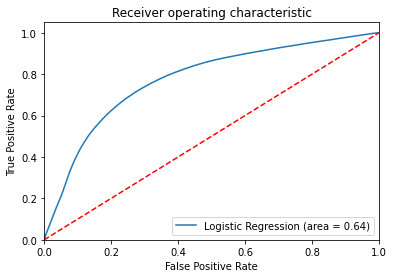

In [71]:
#Create ROC curve
logit_roc_auc = roc_auc_score(y_test, logreg.predict(LR_Xtest))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(LR_Xtest)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [72]:
#Find optimal threshold
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Threshold value is:", optimal_threshold)

Threshold value is: 0.45605703494863475


In [73]:
#results based on optimal threshold
THRESHOLD = optimal_threshold
preds = np.where(logreg.predict_proba(LR_Xtest)[:,1] > THRESHOLD, 1, 0)

tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
(tn, fp, fn, tp)

(160580, 60650, 53207, 133382)

In [74]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

         0.0       0.75      0.73      0.74    221230
         1.0       0.69      0.71      0.70    186589

    accuracy                           0.72    407819
   macro avg       0.72      0.72      0.72    407819
weighted avg       0.72      0.72      0.72    407819



### 2. CatBoost

In [19]:
#split to X and y (target variable)
X_train = train_data.drop(["Item_Bought_flag", "Session ID", "Item ID"], axis=1)
y_train = train_data["Item_Bought_flag"]
#split for test data
X_test = test_data.drop(["Item_Bought_flag", "Session ID", "Item ID"], axis=1)
X_test_ID = test_data[["Session ID", "Item ID"]] #keep ID col separate to test for scores later?
y_test = test_data["Item_Bought_flag"]

In [79]:
params = {'iterations': range(50, 500, 20)}

model = CatBoostClassifier(eval_metric='AUC', learning_rate = 0.2)
ctb = GridSearchCV(model, param_grid=params, cv=5, n_jobs=-1, scoring ='roc_auc', refit=True)
ctb.fit(X_train, y_train)
y_pred = ctb.predict(X_test)

0:	total: 526ms	remaining: 25.8s
1:	total: 1.02s	remaining: 24.4s
2:	total: 1.53s	remaining: 24s
3:	total: 2s	remaining: 23s
4:	total: 2.49s	remaining: 22.4s
5:	total: 2.95s	remaining: 21.6s
6:	total: 3.38s	remaining: 20.8s
7:	total: 3.83s	remaining: 20.1s
8:	total: 4.24s	remaining: 19.3s
9:	total: 4.66s	remaining: 18.6s
10:	total: 5.08s	remaining: 18s
11:	total: 5.5s	remaining: 17.4s
12:	total: 5.92s	remaining: 16.9s
13:	total: 6.35s	remaining: 16.3s
14:	total: 6.73s	remaining: 15.7s
15:	total: 7.21s	remaining: 15.3s
16:	total: 7.66s	remaining: 14.9s
17:	total: 8.06s	remaining: 14.3s
18:	total: 8.52s	remaining: 13.9s
19:	total: 8.97s	remaining: 13.5s
20:	total: 9.37s	remaining: 12.9s
21:	total: 9.89s	remaining: 12.6s
22:	total: 10.3s	remaining: 12.1s
23:	total: 10.7s	remaining: 11.6s
24:	total: 11.1s	remaining: 11.1s
25:	total: 11.5s	remaining: 10.6s
26:	total: 11.9s	remaining: 10.2s
27:	total: 12.4s	remaining: 9.72s
28:	total: 12.8s	remaining: 9.26s
29:	total: 13.2s	remaining: 8.79s


In [80]:
print(ctb.best_estimator_.get_all_params())
print(classification_report(y_test, y_pred), '\n')

{'nan_mode': 'Min', 'eval_metric': 'AUC', 'iterations': 50, 'sampling_frequency': 'PerTree', 'leaf_estimation_method': 'Newton', 'grow_policy': 'SymmetricTree', 'penalties_coefficient': 1, 'boosting_type': 'Plain', 'model_shrink_mode': 'Constant', 'feature_border_type': 'GreedyLogSum', 'bayesian_matrix_reg': 0.10000000149011612, 'l2_leaf_reg': 3, 'random_strength': 1, 'rsm': 1, 'boost_from_average': False, 'model_size_reg': 0.5, 'pool_metainfo_options': {'tags': {}}, 'subsample': 0.800000011920929, 'use_best_model': False, 'class_names': [0, 1], 'random_seed': 0, 'depth': 6, 'posterior_sampling': False, 'border_count': 254, 'classes_count': 0, 'auto_class_weights': 'None', 'sparse_features_conflict_fraction': 0, 'leaf_estimation_backtracking': 'AnyImprovement', 'best_model_min_trees': 1, 'model_shrink_rate': 0, 'min_data_in_leaf': 1, 'loss_function': 'Logloss', 'learning_rate': 0.20000000298023224, 'score_function': 'Cosine', 'task_type': 'CPU', 'leaf_estimation_iterations': 10, 'boots

In [20]:
ctb = CatBoostClassifier(eval_metric='AUC', learning_rate=0.2, iterations=50)
ctb.fit(X_train, y_train)
y_pred = ctb.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
(tn, fp, fn, tp)

0:	total: 471ms	remaining: 23.1s
1:	total: 750ms	remaining: 18s
2:	total: 1.03s	remaining: 16.1s
3:	total: 1.3s	remaining: 14.9s
4:	total: 1.57s	remaining: 14.1s
5:	total: 1.82s	remaining: 13.4s
6:	total: 2.06s	remaining: 12.7s
7:	total: 2.32s	remaining: 12.2s
8:	total: 2.58s	remaining: 11.7s
9:	total: 2.86s	remaining: 11.5s
10:	total: 3.13s	remaining: 11.1s
11:	total: 3.39s	remaining: 10.7s
12:	total: 3.66s	remaining: 10.4s
13:	total: 3.94s	remaining: 10.1s
14:	total: 4.18s	remaining: 9.76s
15:	total: 4.48s	remaining: 9.52s
16:	total: 4.76s	remaining: 9.24s
17:	total: 5.04s	remaining: 8.96s
18:	total: 5.31s	remaining: 8.66s
19:	total: 5.58s	remaining: 8.37s
20:	total: 5.82s	remaining: 8.03s
21:	total: 6.08s	remaining: 7.73s
22:	total: 6.3s	remaining: 7.4s
23:	total: 6.55s	remaining: 7.09s
24:	total: 6.85s	remaining: 6.85s
25:	total: 7.11s	remaining: 6.56s
26:	total: 7.37s	remaining: 6.28s
27:	total: 7.67s	remaining: 6.03s
28:	total: 7.94s	remaining: 5.75s
29:	total: 8.2s	remaining: 5.

(168316, 52914, 40389, 146200)

### 3. Light GBM

In [13]:
#split to X and y (target variable)
X_train = train_data.drop(["Item_Bought_flag", "Session ID", "Item ID"], axis=1)
y_train = train_data["Item_Bought_flag"]
#split for test data
X_test = test_data.drop(["Item_Bought_flag", "Session ID", "Item ID"], axis=1)
X_test_ID = test_data[["Session ID", "Item ID"]] #keep ID col separate to test for scores later?
y_test = test_data["Item_Bought_flag"]

In [14]:
params = {'n_estimators': range(1, 500, 50),
         'boosting_type':['gbdt', 'dart', 'goss', 'rf']}

model = LGBMClassifier(objective = 'binary', learning_rate = 0.2)
lgbm = GridSearchCV(model, param_grid=params, cv=5, n_jobs=-1, scoring ='roc_auc', refit=True)
lgbm.fit(X_train, y_train)
y_pred = lgbm.predict(X_test)

C:\Users\lilya\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:918: UserWarning: One or more of the test scores are non-finite: [0.84669388 0.87877999 0.87790204 0.87583038 0.87394593 0.87169375
 0.87162419 0.87155583 0.87150624 0.87144288 0.84669388 0.87985671
 0.88087178 0.88119498 0.88156351 0.88166179 0.88214619 0.88171654
 0.88079862 0.87963799 0.84669388 0.87744239 0.87680105 0.87680278
 0.87594615 0.87576469 0.87526731 0.87494262 0.87333628 0.87410783
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan]
  warnings.warn(


In [17]:
print(lgbm.best_estimator_)
print(classification_report(y_test, y_pred), '\n')

LGBMClassifier(boosting_type='dart', learning_rate=0.2, n_estimators=301,
               objective='binary')
              precision    recall  f1-score   support

         0.0       0.79      0.78      0.78    221230
         1.0       0.74      0.75      0.75    186589

    accuracy                           0.77    407819
   macro avg       0.77      0.77      0.77    407819
weighted avg       0.77      0.77      0.77    407819
 



In [18]:
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
(tn, fp, fn, tp)

(172444, 48786, 45959, 140630)

### 4. Neural Networks

In [25]:
#split to X and y (target variable)
X_train = train_data.drop(["Item_Bought_flag", "Session ID", "Item ID"], axis=1)
y_train = train_data["Item_Bought_flag"]
#split for test data
X_test = test_data.drop(["Item_Bought_flag", "Session ID", "Item ID"], axis=1)
X_test_ID = test_data[["Session ID", "Item ID"]] #keep ID col separate to test for scores later?
y_test = test_data["Item_Bought_flag"]

In [27]:
scaler = StandardScaler()
NN_Xtrain = scaler.fit_transform(X_train)
NN_Xtest = scaler.transform(X_test)

params = {'activation': ['identity', 'logistic', 'tanh', 'relu'],
          'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
model = MLPClassifier(hidden_layer_sizes = (20, 20), max_iter = 100, solver='adam') 
#2 hidden layers and 'adam' optimizer works well for large dataset
mlp = GridSearchCV(model, param_grid = params, n_jobs=-1, cv=5, scoring='roc_auc', refit=True)
mlp.fit(NN_Xtrain, y_train)
print(mlp.best_estimator_) 

MLPClassifier(alpha=0.1, hidden_layer_sizes=(20, 20), max_iter=100)


In [28]:
y_preds = mlp.predict(NN_Xtest)
print(classification_report(y_test, y_preds))
tn, fp, fn, tp = confusion_matrix(y_test, y_preds).ravel()
print((tn, fp, fn, tp), '\n')

              precision    recall  f1-score   support

         0.0       0.74      0.87      0.80    221230
         1.0       0.80      0.65      0.72    186589

    accuracy                           0.77    407819
   macro avg       0.77      0.76      0.76    407819
weighted avg       0.77      0.77      0.76    407819

(191754, 29476, 65916, 120673) 



### Summary

After implementing 4 models on the full dataset, we observed that CatBoost gives the most balanced performance between recall rates for class 0 and class 1, at 0.76 and 0.78 respectively. Logistic Regression and Light GBM give slightly lower recall rates on average, and Neural Networks does well when it comes to predicting class 0 but not as well for class 1. 